실습 파일: `11-gan.ipynb`

**모델 및 소스코드 참고**  

David Foster저 Generative Deep Learning (O'REILLY출판, 2019)


# Autoencoder

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import os

SAVE_FOLDER = 'data'

if not os.path.exists(SAVE_FOLDER):
    os.mkdir(SAVE_FOLDER)
    os.mkdir(os.path.join(SAVE_FOLDER, 'weights'))

In [2]:

MODE =  'build' #'load' #
#MODE =  'load'

**Encoder 모델 정의**

In [3]:
z_dim = 2

encoder_input = keras.Input(shape=(28, 28, 1), name='encoder_input')
x = Conv2D(32, 3, strides=1, padding="same", name='encoder_conv_0')(encoder_input)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=1, padding="same", name='encoder_conv_3')(x)
x = LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
encoder_output= Dense(z_dim, name='encoder_output')(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

Metal device set to: Apple M1


2023-12-06 17:33:10.390434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 17:33:10.393974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=1, padding="same", name='decoder_conv_t0')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(1, 3, strides=1, padding="same", name='decoder_conv_t3')(x)
decoder_output = Activation('sigmoid')(x)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")

In [5]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 64)          0   

In [6]:
class AutoEncoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def call(self,inputs):
        latent = self.encoder(inputs)
        return self.decoder(latent)

@tf.function
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0
EPOCHS = 200

In [7]:
save_folder = os.path.join(SAVE_FOLDER, 'weights')

ae = AutoEncoder(encoder, decoder)
ae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=r_loss)

if MODE == 'build':
    x = np.random.rand(1,28,28,1)
    ae.predict(x)
    ae.save(save_folder)
else:
    ae = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})
    #ae.load_weights(save_folder+'/'+'checkpoint')

2023-12-06 17:33:12.602299: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-06 17:33:12.936022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


INFO:tensorflow:Assets written to: data/weights/assets


INFO:tensorflow:Assets written to: data/weights/assets


**학습하기**

In [8]:
# mnist 데이터 읽어오기
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))

x_train = x_train/255.
x_test = x_test/255.

# 매 epoch마다 모델 weights 저장
#lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
checkpoint = ModelCheckpoint(save_folder+'/'+'checkpoint', save_weights_only = False, verbose=1)

#callbacks_list = [checkpoint]
callbacks_list = []
ae.fit(x_train[:1000], x_train[:1000], epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list)
ae.save(save_folder)

Epoch 1/200


2023-12-06 17:33:25.414391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 21s 131ms/step - loss: 0.1817
Epoch 2/200
32/32 [==============================] - 2s 49ms/step - loss: 0.0966
Epoch 3/200
32/32 [==============================] - 1s 37ms/step - loss: 0.0700
Epoch 4/200
32/32 [==============================] - 1s 40ms/step - loss: 0.0619
Epoch 5/200
32/32 [==============================] - 1s 43ms/step - loss: 0.0585
Epoch 6/200
32/32 [==============================] - 1s 45ms/step - loss: 0.0565
Epoch 7/200
32/32 [==============================] - 1s 45ms/step - loss: 0.0555
Epoch 8/200
32/32 [==============================] - 1s 36ms/step - loss: 0.0546
Epoch 9/200
32/32 [==============================] - 1s 39ms/step - loss: 0.0538
Epoch 10/200
32/32 [==============================] - 1s 44ms/step - loss: 0.0532
Epoch 11/200
32/32 [==============================] - 1s 43ms/step - loss: 0.0525
Epoch 12/200
32/32 [==============================] - 1s 44ms/step - loss: 0.0521
Epoch 13/200
32/32 [===============

INFO:tensorflow:Assets written to: data/weights/assets


INFO:tensorflow:Assets written to: data/weights/assets


**모델 읽어들이기**

In [9]:

save_folder = os.path.join(SAVE_FOLDER, 'weights')
#AE = AutoEncoder(encoder, decoder)
#AE.load_weights(save_folder+'/'+'checkpoint')
AE = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})


**생성해 보기**

1/1 [==============================] - 0s 22ms/step


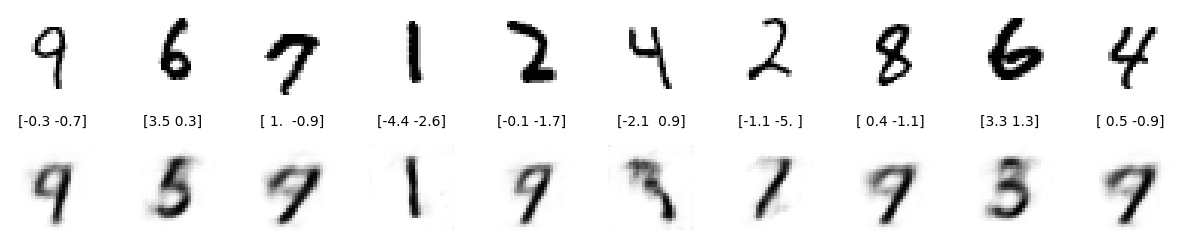

In [14]:
import matplotlib.pyplot as plt

n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = AE.encoder.predict(example_images)

reconst_images = ae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


**Latent space의 분포**

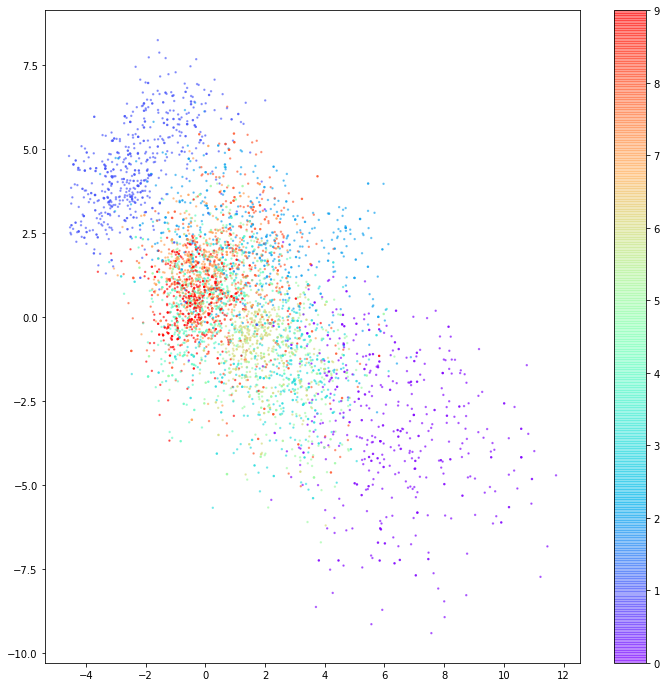

In [ ]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.show()

**Latent space에서 일정 간격으로 latent vector를 추출하여 생성된 결과**

13/13 [==============================] - 0s 5ms/step


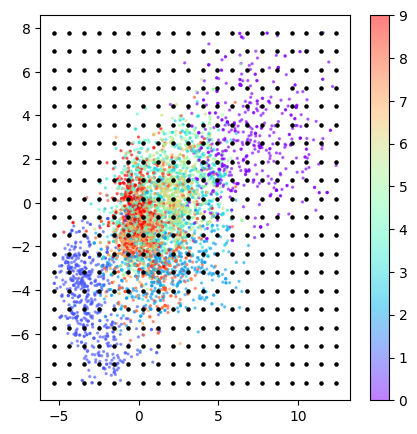

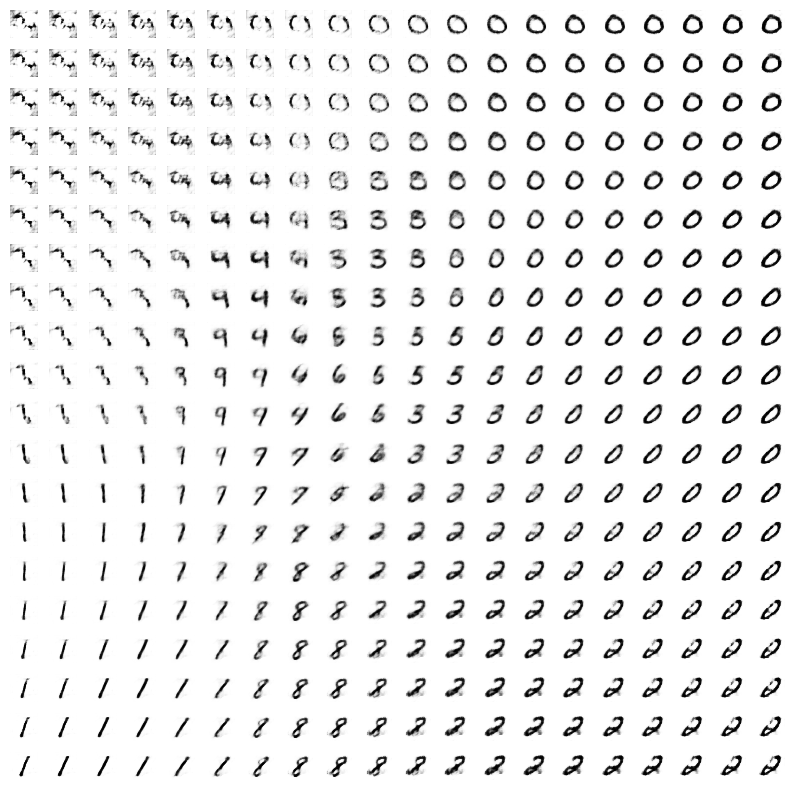

In [17]:
n_to_show = 5000
grid_size = 20
figsize = 10

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)
plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

# GAN

In [18]:
!mkdir -p gan_data/motorbike
!mkdir -p gan_data/images
!mkdir -p gan_data/weights
!gdown --id 1xBCbjopxZCvzzTMuRKKaTpF-i2jLz7xa -O gan_data/motorbike/full_numpy_bitmap_motorbike.npy


/Users/soma/anaconda3/envs/tensor2/lib/python3.9/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1xBCbjopxZCvzzTMuRKKaTpF-i2jLz7xa
From (redirected): https://drive.google.com/uc?id=1xBCbjopxZCvzzTMuRKKaTpF-i2jLz7xa&confirm=t&uuid=5ae0ef40-45ca-463e-b0e6-140615f210a6
To: /Users/soma/IdeaProjects/python_study/딥러닝 컴퓨터비전/gan_data/motorbike/full_numpy_bitmap_motorbike.npy
100%|████████████████████████████████████████| 133M/133M [00:14<00:00, 9.51MB/s]


In [32]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, ReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Input, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
import os
from os import walk
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

**Quick! Draw! database**  
Dataset 홈페이지:  https://quickdraw.withgoogle.com/data  
Motorbike numpy 다운로드: https://console.cloud.google.com/storage/browser/_details/quickdraw_dataset/full/numpy_bitmap/motorbike.npy  

Quick & Draw 참여 페이지  
https://quickdraw.withgoogle.com/  


In [33]:
SAVE_FOLDER = 'gan_data'

def load_quickdraw(folder):

    mypath = os.path.join(SAVE_FOLDER, folder)
    txt_name_list = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        for f in filenames:
            if f != '.DS_Store':
                txt_name_list.append(f)
                break

    slice_train = int(80000/len(txt_name_list))  ###Setting value to be 80000 for the final dataset
    i = 0
    seed = np.random.randint(1, 10e6)

    for txt_name in txt_name_list:
        txt_path = os.path.join(mypath,txt_name)
        x = np.load(txt_path)
        x = (x.astype('float32') - 127.5) / 127.5
        # x = x.astype('float32') / 255.0

        x = x.reshape(x.shape[0], 28, 28, 1)

        y = [i] * len(x)
        np.random.seed(seed)
        np.random.shuffle(x)
        np.random.seed(seed)
        np.random.shuffle(y)
        x = x[:slice_train]
        y = y[:slice_train]
        if i != 0:
            xtotal = np.concatenate((x,xtotal), axis=0)
            ytotal = np.concatenate((y,ytotal), axis=0)
        else:
            xtotal = x
            ytotal = y
        i += 1

    return xtotal, ytotal

In [34]:
x_train, y_train = load_quickdraw('motorbike')

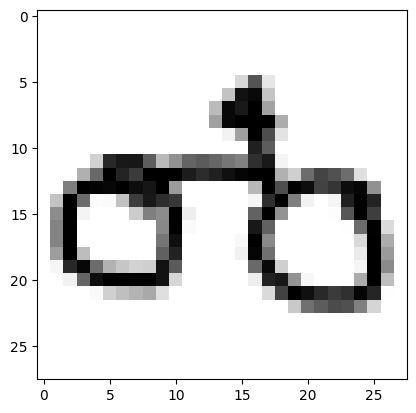

In [35]:
plt.imshow(x_train[501,:,:,0], cmap = 'binary')
plt.show()

입력 이미지 사이즈: (28,28)

In [36]:
input_dim = (28,28,1)
weight_init = RandomNormal(mean=0., stddev=0.02)

**Discriminator 모델 정의**

In [37]:
discriminator_input = keras.Input(shape=input_dim, name='discriminator_input')
x = Conv2D(64, 5, strides=2, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_0')(discriminator_input)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(64, 5, strides=2, padding="same",
    kernel_initializer=weight_init, name='discriminator_conv_1')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(128, 5, strides=2, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_2')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(128, 5, strides=1, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_3')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Flatten()(x)
discriminator_output = Dense(1, activation='sigmoid',
    kernel_initializer = RandomNormal(mean=0., stddev=0.02))(x)
discriminator = keras.Model(discriminator_input, discriminator_output, name = 'discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 discriminator_conv_0 (Conv2  (None, 14, 14, 64)       1664      
 D)                                                              
                                                                 
 re_lu_8 (ReLU)              (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 discriminator_conv_1 (Conv2  (None, 7, 7, 64)         102464    
 D)                                                              
                                                     

/Users/soma/anaconda3/envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


**Generator 모델 정의**

In [38]:
z_dim = 100

generator_input = keras.Input(shape=(z_dim,), name='generator_input')
x = Dense(np.prod((7, 7, 64)), kernel_initializer = RandomNormal(mean=0., stddev=0.02))(generator_input)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Reshape((7,7,64))(x)
x = UpSampling2D()(x)
x = Conv2D(128, 5, padding="same", kernel_initializer=weight_init, name='generator_conv_0')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(64, 5, padding="same", kernel_initializer=weight_init, name='generator_conv_1')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Conv2DTranspose(64, 5, strides=1, padding="same", kernel_initializer=weight_init, name='generator_conv_2')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Conv2DTranspose(1, 5, strides=1, padding="same", kernel_initializer=weight_init, name='generator_conv_3')(x)
generator_output = Activation('tanh')(x)
generator = keras.Model(generator_input, generator_output, name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 100)]            0         
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization_4 (Batc  (None, 3136)             12544     
 hNormalization)                                                 
                                                                 
 re_lu_12 (ReLU)             (None, 3136)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 64)       0 

Discriminator를 먼저 컴파일

In [39]:
### COMPILE DISCRIMINATOR

discriminator.compile(
  optimizer=RMSprop(lr=0.0008),
  loss = 'binary_crossentropy',
  metrics = ['accuracy']
)

/Users/soma/anaconda3/envs/tensor2/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Discriminator를 freeze하고, generator와 연결하여  
model을 정의  
Generator용 모델 컴파일  

In [40]:
### COMPILE THE FULL GAN

def set_trainable(m, val):
    m.trainable = val
    for l in m.layers:
        l.trainable = val

# 먼저discriminator를 훈련 불가능 상태로 만듬.
set_trainable(discriminator, False)

model_input = Input(shape=(z_dim,), name='model_input')
model_output = discriminator(generator(model_input))
model = Model(model_input, model_output)

model.compile(optimizer=RMSprop(learning_rate=0.0004) , loss='binary_crossentropy', metrics=['accuracy']
  , experimental_run_tf_function=False
)

# compile이 완료되었으므로, discriminator를 훈련 가능 상태로 복귀.
set_trainable(discriminator, True)

최초 실행시에는 `build`를 사용  
저장된 weights를 loading해서 계속할 때에는 `load`사용

In [45]:
mode = 'build'
#mode = 'load'

if mode == 'build':
    model.save(SAVE_FOLDER)
else:
    model.load_weights(os.path.join(SAVE_FOLDER, 'weights/weights.h5'))

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


d,g의 loss 및 accuracy를 저장해 두는 변수

In [46]:
total_epoch = 0
d_losses = []
g_losses = []

**GAN 학습**

In [43]:
def train_discriminator(x_train, batch_size):

    valid = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    true_imgs = x_train[idx]

    noise = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(noise)

    d_loss_real, d_acc_real =   discriminator.train_on_batch(true_imgs, valid)
    d_loss_fake, d_acc_fake =   discriminator.train_on_batch(gen_imgs, fake)
    d_loss =  0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]

def train_generator(batch_size):
    valid = np.ones((batch_size,1))
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    return model.train_on_batch(noise, valid)



# 중간 epoch에서 생성 이미지를 샘플링하여 저장해두기 위한 함수
def sample_images(run_folder):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * (gen_imgs + 1)
    gen_imgs = np.clip(gen_imgs, 0, 1)

    fig, axs = plt.subplots(r, c, figsize=(15,15))
    cnt = 0

    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % total_epoch))
    plt.close()

# discriminator와 generator를 번갈아가며, 학습
def train(x_train, batch_size, epochs, run_folder,
          print_every_n_batches = 50,
          ):

    global total_epoch
    for epoch in range(total_epoch, total_epoch + epochs):

        d = train_discriminator(x_train, batch_size)
        g = train_generator(batch_size)

        print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

        d_losses.append(d)
        g_losses.append(g)

        if epoch % print_every_n_batches == 0:
            sample_images(run_folder)
            #model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
            model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
            model.save(run_folder)

        total_epoch += 1


In [44]:
BATCH_SIZE = 64
EPOCHS = 2000
PRINT_EVERY_N_BATCHES = 20

train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    run_folder = SAVE_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
)

2023-12-06 17:49:24.472648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 21ms/step


2023-12-06 17:49:25.050979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

0 [D loss: (0.734)(R 0.684, F 0.785)] [D acc: (0.438)(0.875, 0.000)] [G loss: 0.678] [G acc: 1.000]
1/1 [==============================] - 0s 209ms/step


2023-12-06 17:49:28.338165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 40ms/step
1 [D loss: (1.156)(R 0.604, F 1.709)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.650] [G acc: 1.000]
2/2 [==============================] - 0s 25ms/step
2 [D loss: (0.669)(R 0.637, F 0.702)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.610] [G acc: 1.000]
2/2 [==============================] - 0s 31ms/step
3 [D loss: (0.651)(R 0.604, F 0.698)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.537] [G acc: 1.000]
2/2 [==============================] - 0s 21ms/step
4 [D loss: (0.632)(R 0.526, F 0.737)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.329] [G acc: 1.000]
2/2 [==============================] - 0s 26ms/step
5 [D loss: (0.625)(R 0.355, F 0.895)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.209] [G acc: 1.000]
2/2 [==============================] - 0s 25ms/step
6 [D loss: (0.681)(R 0.247, F 1.114)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.350] [G acc: 1.000]
2/2 [==============================] - 0s 22ms/step
7 [D loss: (0.687)(R 0.359, F 1.016)

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 35ms/step
21 [D loss: (0.583)(R 0.953, F 0.212)] [D acc: (0.734)(0.469, 1.000)] [G loss: 0.211] [G acc: 1.000]
2/2 [==============================] - 0s 29ms/step
22 [D loss: (0.113)(R 0.168, F 0.058)] [D acc: (1.000)(1.000, 1.000)] [G loss: 0.111] [G acc: 1.000]
2/2 [==============================] - 0s 31ms/step
23 [D loss: (0.046)(R 0.073, F 0.019)] [D acc: (1.000)(1.000, 1.000)] [G loss: 0.059] [G acc: 1.000]
2/2 [==============================] - 0s 27ms/step
24 [D loss: (0.038)(R 0.065, F 0.011)] [D acc: (1.000)(1.000, 1.000)] [G loss: 0.031] [G acc: 1.000]
2/2 [==============================] - 0s 27ms/step
25 [D loss: (0.029)(R 0.051, F 0.008)] [D acc: (0.992)(0.984, 1.000)] [G loss: 0.018] [G acc: 1.000]
2/2 [==============================] - 0s 31ms/step
26 [D loss: (0.029)(R 0.019, F 0.039)] [D acc: (0.992)(1.000, 0.984)] [G loss: 0.010] [G acc: 1.000]
2/2 [==============================] - 0s 26ms/step
27 [D loss: (0.008)(R 0.011, F

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 30ms/step
41 [D loss: (0.706)(R 0.628, F 0.784)] [D acc: (0.469)(0.875, 0.062)] [G loss: 0.696] [G acc: 0.516]
2/2 [==============================] - 0s 22ms/step
42 [D loss: (0.694)(R 0.602, F 0.786)] [D acc: (0.461)(0.906, 0.016)] [G loss: 0.683] [G acc: 0.578]
2/2 [==============================] - 0s 22ms/step
43 [D loss: (0.683)(R 0.583, F 0.783)] [D acc: (0.500)(0.969, 0.031)] [G loss: 0.682] [G acc: 0.625]
2/2 [==============================] - 0s 23ms/step
44 [D loss: (0.685)(R 0.571, F 0.798)] [D acc: (0.508)(1.000, 0.016)] [G loss: 0.676] [G acc: 0.734]
2/2 [==============================] - 0s 23ms/step
45 [D loss: (0.682)(R 0.570, F 0.795)] [D acc: (0.508)(0.984, 0.031)] [G loss: 0.682] [G acc: 0.609]
2/2 [==============================] - 0s 28ms/step
46 [D loss: (0.680)(R 0.551, F 0.808)] [D acc: (0.508)(1.000, 0.016)] [G loss: 0.679] [G acc: 0.594]
2/2 [==============================] - 0s 22ms/step
47 [D loss: (0.689)(R 0.554, F

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 34ms/step
61 [D loss: (0.652)(R 0.557, F 0.746)] [D acc: (0.602)(0.859, 0.344)] [G loss: 0.751] [G acc: 0.188]
2/2 [==============================] - 0s 21ms/step
62 [D loss: (0.657)(R 0.501, F 0.814)] [D acc: (0.500)(0.875, 0.125)] [G loss: 0.765] [G acc: 0.109]
2/2 [==============================] - 0s 21ms/step
63 [D loss: (0.679)(R 0.545, F 0.814)] [D acc: (0.492)(0.766, 0.219)] [G loss: 0.743] [G acc: 0.156]
2/2 [==============================] - 0s 32ms/step
64 [D loss: (0.642)(R 0.517, F 0.767)] [D acc: (0.625)(0.875, 0.375)] [G loss: 0.755] [G acc: 0.188]
2/2 [==============================] - 0s 25ms/step
65 [D loss: (0.671)(R 0.567, F 0.775)] [D acc: (0.516)(0.750, 0.281)] [G loss: 0.737] [G acc: 0.172]
2/2 [==============================] - 0s 26ms/step
66 [D loss: (0.643)(R 0.568, F 0.718)] [D acc: (0.570)(0.781, 0.359)] [G loss: 0.751] [G acc: 0.109]
2/2 [==============================] - 0s 29ms/step
67 [D loss: (0.680)(R 0.505, F

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 30ms/step
81 [D loss: (0.689)(R 0.688, F 0.690)] [D acc: (0.555)(0.406, 0.703)] [G loss: 0.698] [G acc: 0.266]
2/2 [==============================] - 0s 22ms/step
82 [D loss: (0.715)(R 0.677, F 0.753)] [D acc: (0.430)(0.609, 0.250)] [G loss: 0.681] [G acc: 0.453]
2/2 [==============================] - 0s 22ms/step
83 [D loss: (0.772)(R 0.692, F 0.852)] [D acc: (0.266)(0.422, 0.109)] [G loss: 0.704] [G acc: 0.078]
2/2 [==============================] - 0s 24ms/step
84 [D loss: (0.699)(R 0.702, F 0.697)] [D acc: (0.469)(0.234, 0.703)] [G loss: 0.701] [G acc: 0.094]
2/2 [==============================] - 0s 23ms/step
85 [D loss: (0.697)(R 0.703, F 0.690)] [D acc: (0.469)(0.188, 0.750)] [G loss: 0.701] [G acc: 0.156]
2/2 [==============================] - 0s 23ms/step
86 [D loss: (0.697)(R 0.703, F 0.691)] [D acc: (0.453)(0.125, 0.781)] [G loss: 0.704] [G acc: 0.047]
2/2 [==============================] - 0s 22ms/step
87 [D loss: (0.696)(R 0.703, F

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 35ms/step
101 [D loss: (0.693)(R 0.696, F 0.689)] [D acc: (0.492)(0.219, 0.766)] [G loss: 0.702] [G acc: 0.109]
2/2 [==============================] - 0s 22ms/step
102 [D loss: (0.692)(R 0.692, F 0.691)] [D acc: (0.547)(0.281, 0.812)] [G loss: 0.701] [G acc: 0.094]
2/2 [==============================] - 0s 22ms/step
103 [D loss: (0.691)(R 0.693, F 0.689)] [D acc: (0.516)(0.266, 0.766)] [G loss: 0.701] [G acc: 0.172]
2/2 [==============================] - 0s 23ms/step
104 [D loss: (0.692)(R 0.690, F 0.693)] [D acc: (0.555)(0.422, 0.688)] [G loss: 0.700] [G acc: 0.156]
2/2 [==============================] - 0s 24ms/step
105 [D loss: (0.690)(R 0.685, F 0.696)] [D acc: (0.516)(0.438, 0.594)] [G loss: 0.702] [G acc: 0.234]
2/2 [==============================] - 0s 23ms/step
106 [D loss: (0.689)(R 0.677, F 0.702)] [D acc: (0.523)(0.484, 0.562)] [G loss: 0.708] [G acc: 0.031]
2/2 [==============================] - 0s 25ms/step
107 [D loss: (0.703)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 34ms/step
121 [D loss: (0.695)(R 0.691, F 0.699)] [D acc: (0.438)(0.359, 0.516)] [G loss: 0.702] [G acc: 0.031]
2/2 [==============================] - 0s 21ms/step
122 [D loss: (0.691)(R 0.690, F 0.691)] [D acc: (0.570)(0.406, 0.734)] [G loss: 0.702] [G acc: 0.094]
2/2 [==============================] - 0s 21ms/step
123 [D loss: (0.693)(R 0.687, F 0.699)] [D acc: (0.508)(0.344, 0.672)] [G loss: 0.701] [G acc: 0.125]
2/2 [==============================] - 0s 23ms/step
124 [D loss: (0.693)(R 0.689, F 0.697)] [D acc: (0.508)(0.359, 0.656)] [G loss: 0.703] [G acc: 0.094]
2/2 [==============================] - 0s 22ms/step
125 [D loss: (0.693)(R 0.689, F 0.697)] [D acc: (0.547)(0.391, 0.703)] [G loss: 0.700] [G acc: 0.141]
2/2 [==============================] - 0s 21ms/step
126 [D loss: (0.693)(R 0.684, F 0.701)] [D acc: (0.516)(0.406, 0.625)] [G loss: 0.704] [G acc: 0.078]
2/2 [==============================] - 0s 27ms/step
127 [D loss: (0.692)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 38ms/step
141 [D loss: (0.685)(R 0.671, F 0.700)] [D acc: (0.617)(0.562, 0.672)] [G loss: 0.696] [G acc: 0.328]
2/2 [==============================] - 0s 26ms/step
142 [D loss: (0.703)(R 0.646, F 0.761)] [D acc: (0.391)(0.688, 0.094)] [G loss: 0.709] [G acc: 0.000]
2/2 [==============================] - 0s 21ms/step
143 [D loss: (0.680)(R 0.672, F 0.689)] [D acc: (0.656)(0.500, 0.812)] [G loss: 0.697] [G acc: 0.250]
2/2 [==============================] - 0s 23ms/step
144 [D loss: (0.695)(R 0.655, F 0.736)] [D acc: (0.500)(0.609, 0.391)] [G loss: 0.699] [G acc: 0.141]
2/2 [==============================] - 0s 21ms/step
145 [D loss: (0.690)(R 0.671, F 0.708)] [D acc: (0.500)(0.500, 0.500)] [G loss: 0.699] [G acc: 0.203]
2/2 [==============================] - 0s 22ms/step
146 [D loss: (0.684)(R 0.658, F 0.711)] [D acc: (0.570)(0.625, 0.516)] [G loss: 0.702] [G acc: 0.125]
2/2 [==============================] - 0s 28ms/step
147 [D loss: (0.686)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 44ms/step
161 [D loss: (0.689)(R 0.676, F 0.702)] [D acc: (0.578)(0.609, 0.547)] [G loss: 0.704] [G acc: 0.203]
2/2 [==============================] - 0s 23ms/step
162 [D loss: (0.714)(R 0.671, F 0.758)] [D acc: (0.406)(0.594, 0.219)] [G loss: 0.710] [G acc: 0.000]
2/2 [==============================] - 0s 26ms/step
163 [D loss: (0.689)(R 0.691, F 0.686)] [D acc: (0.609)(0.297, 0.922)] [G loss: 0.709] [G acc: 0.016]
2/2 [==============================] - 0s 24ms/step
164 [D loss: (0.693)(R 0.683, F 0.703)] [D acc: (0.492)(0.344, 0.641)] [G loss: 0.705] [G acc: 0.047]
2/2 [==============================] - 0s 26ms/step
165 [D loss: (0.684)(R 0.681, F 0.688)] [D acc: (0.586)(0.359, 0.812)] [G loss: 0.703] [G acc: 0.156]
2/2 [==============================] - 0s 22ms/step
166 [D loss: (0.692)(R 0.648, F 0.737)] [D acc: (0.484)(0.641, 0.328)] [G loss: 0.703] [G acc: 0.125]
2/2 [==============================] - 0s 22ms/step
167 [D loss: (0.688)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 37ms/step
181 [D loss: (0.723)(R 0.664, F 0.781)] [D acc: (0.414)(0.531, 0.297)] [G loss: 0.703] [G acc: 0.156]
2/2 [==============================] - 0s 24ms/step
182 [D loss: (0.685)(R 0.685, F 0.686)] [D acc: (0.609)(0.375, 0.844)] [G loss: 0.708] [G acc: 0.078]
2/2 [==============================] - 0s 27ms/step
183 [D loss: (0.704)(R 0.683, F 0.724)] [D acc: (0.531)(0.531, 0.531)] [G loss: 0.700] [G acc: 0.172]
2/2 [==============================] - 0s 23ms/step
184 [D loss: (0.694)(R 0.685, F 0.702)] [D acc: (0.508)(0.438, 0.578)] [G loss: 0.700] [G acc: 0.188]
2/2 [==============================] - 0s 22ms/step
185 [D loss: (0.702)(R 0.695, F 0.710)] [D acc: (0.477)(0.328, 0.625)] [G loss: 0.705] [G acc: 0.078]
2/2 [==============================] - 0s 21ms/step
186 [D loss: (0.695)(R 0.695, F 0.694)] [D acc: (0.547)(0.312, 0.781)] [G loss: 0.704] [G acc: 0.078]
2/2 [==============================] - 0s 21ms/step
187 [D loss: (0.697)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 32ms/step
201 [D loss: (0.693)(R 0.696, F 0.690)] [D acc: (0.555)(0.297, 0.812)] [G loss: 0.705] [G acc: 0.031]
2/2 [==============================] - 0s 25ms/step
202 [D loss: (0.694)(R 0.700, F 0.688)] [D acc: (0.500)(0.172, 0.828)] [G loss: 0.705] [G acc: 0.016]
2/2 [==============================] - 0s 22ms/step
203 [D loss: (0.692)(R 0.699, F 0.685)] [D acc: (0.539)(0.141, 0.938)] [G loss: 0.703] [G acc: 0.047]
2/2 [==============================] - 0s 21ms/step
204 [D loss: (0.693)(R 0.693, F 0.693)] [D acc: (0.531)(0.344, 0.719)] [G loss: 0.704] [G acc: 0.094]
2/2 [==============================] - 0s 24ms/step
205 [D loss: (0.692)(R 0.687, F 0.697)] [D acc: (0.555)(0.406, 0.703)] [G loss: 0.704] [G acc: 0.078]
2/2 [==============================] - 0s 22ms/step
206 [D loss: (0.691)(R 0.688, F 0.694)] [D acc: (0.562)(0.375, 0.750)] [G loss: 0.701] [G acc: 0.078]
2/2 [==============================] - 0s 23ms/step
207 [D loss: (0.689)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 32ms/step
221 [D loss: (0.677)(R 0.674, F 0.680)] [D acc: (0.609)(0.484, 0.734)] [G loss: 0.701] [G acc: 0.344]
2/2 [==============================] - 0s 21ms/step
222 [D loss: (0.694)(R 0.640, F 0.747)] [D acc: (0.547)(0.672, 0.422)] [G loss: 0.725] [G acc: 0.141]
2/2 [==============================] - 0s 24ms/step
223 [D loss: (0.649)(R 0.646, F 0.653)] [D acc: (0.766)(0.641, 0.891)] [G loss: 0.740] [G acc: 0.312]
2/2 [==============================] - 0s 20ms/step
224 [D loss: (0.691)(R 0.597, F 0.786)] [D acc: (0.453)(0.656, 0.250)] [G loss: 0.745] [G acc: 0.109]
2/2 [==============================] - 0s 24ms/step
225 [D loss: (0.723)(R 0.635, F 0.810)] [D acc: (0.461)(0.641, 0.281)] [G loss: 0.685] [G acc: 0.422]
2/2 [==============================] - 0s 24ms/step
226 [D loss: (0.715)(R 0.686, F 0.744)] [D acc: (0.398)(0.484, 0.312)] [G loss: 0.697] [G acc: 0.312]
2/2 [==============================] - 0s 22ms/step
227 [D loss: (0.704)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 31ms/step
241 [D loss: (0.691)(R 0.697, F 0.686)] [D acc: (0.570)(0.328, 0.812)] [G loss: 0.709] [G acc: 0.047]
2/2 [==============================] - 0s 20ms/step
242 [D loss: (0.692)(R 0.699, F 0.686)] [D acc: (0.547)(0.281, 0.812)] [G loss: 0.708] [G acc: 0.047]
2/2 [==============================] - 0s 21ms/step
243 [D loss: (0.691)(R 0.695, F 0.686)] [D acc: (0.547)(0.297, 0.797)] [G loss: 0.709] [G acc: 0.062]
2/2 [==============================] - 0s 21ms/step
244 [D loss: (0.688)(R 0.690, F 0.687)] [D acc: (0.555)(0.344, 0.766)] [G loss: 0.707] [G acc: 0.078]
2/2 [==============================] - 0s 22ms/step
245 [D loss: (0.691)(R 0.686, F 0.695)] [D acc: (0.539)(0.516, 0.562)] [G loss: 0.701] [G acc: 0.234]
2/2 [==============================] - 0s 89ms/step
246 [D loss: (0.694)(R 0.689, F 0.699)] [D acc: (0.461)(0.359, 0.562)] [G loss: 0.704] [G acc: 0.156]
2/2 [==============================] - 0s 89ms/step
247 [D loss: (0.689)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 31ms/step
261 [D loss: (0.694)(R 0.690, F 0.698)] [D acc: (0.461)(0.328, 0.594)] [G loss: 0.706] [G acc: 0.125]
2/2 [==============================] - 0s 20ms/step
262 [D loss: (0.690)(R 0.691, F 0.689)] [D acc: (0.539)(0.344, 0.734)] [G loss: 0.703] [G acc: 0.219]
2/2 [==============================] - 0s 23ms/step
263 [D loss: (0.692)(R 0.682, F 0.702)] [D acc: (0.516)(0.422, 0.609)] [G loss: 0.705] [G acc: 0.141]
2/2 [==============================] - 0s 23ms/step
264 [D loss: (0.691)(R 0.694, F 0.688)] [D acc: (0.562)(0.375, 0.750)] [G loss: 0.700] [G acc: 0.266]
2/2 [==============================] - 0s 23ms/step
265 [D loss: (0.686)(R 0.676, F 0.695)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.700] [G acc: 0.266]
2/2 [==============================] - 0s 22ms/step
266 [D loss: (0.702)(R 0.679, F 0.725)] [D acc: (0.445)(0.594, 0.297)] [G loss: 0.700] [G acc: 0.297]
2/2 [==============================] - 0s 21ms/step
267 [D loss: (0.703)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 35ms/step
281 [D loss: (0.690)(R 0.695, F 0.685)] [D acc: (0.492)(0.328, 0.656)] [G loss: 0.710] [G acc: 0.156]
2/2 [==============================] - 0s 20ms/step
282 [D loss: (0.697)(R 0.694, F 0.699)] [D acc: (0.461)(0.422, 0.500)] [G loss: 0.707] [G acc: 0.156]
2/2 [==============================] - 0s 28ms/step
283 [D loss: (0.692)(R 0.692, F 0.691)] [D acc: (0.547)(0.359, 0.734)] [G loss: 0.707] [G acc: 0.219]
2/2 [==============================] - 0s 23ms/step
284 [D loss: (0.694)(R 0.695, F 0.694)] [D acc: (0.469)(0.391, 0.547)] [G loss: 0.704] [G acc: 0.203]
2/2 [==============================] - 0s 21ms/step
285 [D loss: (0.689)(R 0.688, F 0.691)] [D acc: (0.578)(0.484, 0.672)] [G loss: 0.701] [G acc: 0.266]
2/2 [==============================] - 0s 21ms/step
286 [D loss: (0.697)(R 0.689, F 0.705)] [D acc: (0.422)(0.422, 0.422)] [G loss: 0.719] [G acc: 0.156]
2/2 [==============================] - 0s 21ms/step
287 [D loss: (0.698)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 31ms/step
301 [D loss: (0.727)(R 0.623, F 0.831)] [D acc: (0.453)(0.750, 0.156)] [G loss: 0.700] [G acc: 0.281]
2/2 [==============================] - 0s 20ms/step
302 [D loss: (0.702)(R 0.680, F 0.723)] [D acc: (0.523)(0.562, 0.484)] [G loss: 0.712] [G acc: 0.172]
2/2 [==============================] - 0s 21ms/step
303 [D loss: (0.683)(R 0.667, F 0.699)] [D acc: (0.562)(0.578, 0.547)] [G loss: 0.686] [G acc: 0.422]
2/2 [==============================] - 0s 21ms/step
304 [D loss: (0.682)(R 0.657, F 0.706)] [D acc: (0.648)(0.703, 0.594)] [G loss: 0.695] [G acc: 0.422]
2/2 [==============================] - 0s 22ms/step
305 [D loss: (0.679)(R 0.653, F 0.706)] [D acc: (0.609)(0.734, 0.484)] [G loss: 0.726] [G acc: 0.109]
2/2 [==============================] - 0s 21ms/step
306 [D loss: (0.726)(R 0.647, F 0.805)] [D acc: (0.414)(0.656, 0.172)] [G loss: 0.702] [G acc: 0.219]
2/2 [==============================] - 0s 22ms/step
307 [D loss: (0.692)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 34ms/step
321 [D loss: (0.676)(R 0.637, F 0.716)] [D acc: (0.570)(0.703, 0.438)] [G loss: 0.709] [G acc: 0.266]
2/2 [==============================] - 0s 20ms/step
322 [D loss: (0.663)(R 0.638, F 0.688)] [D acc: (0.617)(0.656, 0.578)] [G loss: 0.741] [G acc: 0.219]
2/2 [==============================] - 0s 20ms/step
323 [D loss: (0.715)(R 0.641, F 0.788)] [D acc: (0.562)(0.734, 0.391)] [G loss: 0.715] [G acc: 0.234]
2/2 [==============================] - 0s 23ms/step
324 [D loss: (0.693)(R 0.665, F 0.721)] [D acc: (0.516)(0.562, 0.469)] [G loss: 0.699] [G acc: 0.297]
2/2 [==============================] - 0s 27ms/step
325 [D loss: (0.706)(R 0.665, F 0.747)] [D acc: (0.453)(0.500, 0.406)] [G loss: 0.691] [G acc: 0.422]
2/2 [==============================] - 0s 21ms/step
326 [D loss: (0.679)(R 0.647, F 0.712)] [D acc: (0.570)(0.641, 0.500)] [G loss: 0.697] [G acc: 0.328]
2/2 [==============================] - 0s 22ms/step
327 [D loss: (0.681)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 31ms/step
341 [D loss: (0.679)(R 0.655, F 0.704)] [D acc: (0.641)(0.750, 0.531)] [G loss: 0.704] [G acc: 0.312]
2/2 [==============================] - 0s 20ms/step
342 [D loss: (0.700)(R 0.644, F 0.757)] [D acc: (0.555)(0.750, 0.359)] [G loss: 0.709] [G acc: 0.312]
2/2 [==============================] - 0s 20ms/step
343 [D loss: (0.690)(R 0.674, F 0.707)] [D acc: (0.477)(0.547, 0.406)] [G loss: 0.702] [G acc: 0.328]
2/2 [==============================] - 0s 19ms/step
344 [D loss: (0.682)(R 0.667, F 0.697)] [D acc: (0.656)(0.672, 0.641)] [G loss: 0.712] [G acc: 0.250]
2/2 [==============================] - 0s 19ms/step
345 [D loss: (0.698)(R 0.661, F 0.735)] [D acc: (0.555)(0.672, 0.438)] [G loss: 0.698] [G acc: 0.406]
2/2 [==============================] - 0s 18ms/step
346 [D loss: (0.686)(R 0.660, F 0.712)] [D acc: (0.562)(0.625, 0.500)] [G loss: 0.708] [G acc: 0.281]
2/2 [==============================] - 0s 19ms/step
347 [D loss: (0.704)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 30ms/step
361 [D loss: (0.689)(R 0.636, F 0.742)] [D acc: (0.531)(0.625, 0.438)] [G loss: 0.705] [G acc: 0.359]
2/2 [==============================] - 0s 21ms/step
362 [D loss: (0.713)(R 0.646, F 0.779)] [D acc: (0.492)(0.641, 0.344)] [G loss: 0.708] [G acc: 0.234]
2/2 [==============================] - 0s 22ms/step
363 [D loss: (0.681)(R 0.650, F 0.712)] [D acc: (0.609)(0.656, 0.562)] [G loss: 0.714] [G acc: 0.234]
2/2 [==============================] - 0s 20ms/step
364 [D loss: (0.693)(R 0.649, F 0.737)] [D acc: (0.562)(0.656, 0.469)] [G loss: 0.722] [G acc: 0.250]
2/2 [==============================] - 0s 21ms/step
365 [D loss: (0.676)(R 0.660, F 0.692)] [D acc: (0.578)(0.578, 0.578)] [G loss: 0.749] [G acc: 0.078]
2/2 [==============================] - 0s 20ms/step
366 [D loss: (0.682)(R 0.681, F 0.683)] [D acc: (0.625)(0.531, 0.719)] [G loss: 0.732] [G acc: 0.141]
2/2 [==============================] - 0s 20ms/step
367 [D loss: (0.699)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 32ms/step
381 [D loss: (0.720)(R 0.634, F 0.806)] [D acc: (0.539)(0.641, 0.438)] [G loss: 0.715] [G acc: 0.297]
2/2 [==============================] - 0s 20ms/step
382 [D loss: (0.685)(R 0.647, F 0.724)] [D acc: (0.594)(0.609, 0.578)] [G loss: 0.708] [G acc: 0.297]
2/2 [==============================] - 0s 20ms/step
383 [D loss: (0.690)(R 0.644, F 0.736)] [D acc: (0.539)(0.672, 0.406)] [G loss: 0.711] [G acc: 0.266]
2/2 [==============================] - 0s 23ms/step
384 [D loss: (0.674)(R 0.645, F 0.702)] [D acc: (0.625)(0.609, 0.641)] [G loss: 0.730] [G acc: 0.219]
2/2 [==============================] - 0s 20ms/step
385 [D loss: (0.698)(R 0.642, F 0.753)] [D acc: (0.469)(0.609, 0.328)] [G loss: 0.709] [G acc: 0.328]
2/2 [==============================] - 0s 20ms/step
386 [D loss: (0.685)(R 0.658, F 0.713)] [D acc: (0.555)(0.562, 0.547)] [G loss: 0.707] [G acc: 0.375]
2/2 [==============================] - 0s 20ms/step
387 [D loss: (0.697)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 28ms/step
401 [D loss: (0.673)(R 0.615, F 0.731)] [D acc: (0.633)(0.734, 0.531)] [G loss: 0.715] [G acc: 0.297]
2/2 [==============================] - 0s 21ms/step
402 [D loss: (0.684)(R 0.643, F 0.726)] [D acc: (0.516)(0.625, 0.406)] [G loss: 0.715] [G acc: 0.281]
2/2 [==============================] - 0s 20ms/step
403 [D loss: (0.695)(R 0.654, F 0.736)] [D acc: (0.555)(0.641, 0.469)] [G loss: 0.732] [G acc: 0.219]
2/2 [==============================] - 0s 21ms/step
404 [D loss: (0.693)(R 0.675, F 0.712)] [D acc: (0.477)(0.516, 0.438)] [G loss: 0.706] [G acc: 0.328]
2/2 [==============================] - 0s 19ms/step
405 [D loss: (0.685)(R 0.661, F 0.710)] [D acc: (0.562)(0.609, 0.516)] [G loss: 0.722] [G acc: 0.250]
2/2 [==============================] - 0s 22ms/step
406 [D loss: (0.686)(R 0.652, F 0.721)] [D acc: (0.539)(0.641, 0.438)] [G loss: 0.709] [G acc: 0.344]
2/2 [==============================] - 0s 19ms/step
407 [D loss: (0.673)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 34ms/step
421 [D loss: (0.689)(R 0.630, F 0.748)] [D acc: (0.602)(0.672, 0.531)] [G loss: 0.731] [G acc: 0.156]
2/2 [==============================] - 0s 20ms/step
422 [D loss: (0.688)(R 0.643, F 0.734)] [D acc: (0.531)(0.547, 0.516)] [G loss: 0.708] [G acc: 0.281]
2/2 [==============================] - 0s 22ms/step
423 [D loss: (0.708)(R 0.663, F 0.753)] [D acc: (0.438)(0.469, 0.406)] [G loss: 0.722] [G acc: 0.234]
2/2 [==============================] - 0s 20ms/step
424 [D loss: (0.671)(R 0.669, F 0.672)] [D acc: (0.625)(0.516, 0.734)] [G loss: 0.718] [G acc: 0.312]
2/2 [==============================] - 0s 20ms/step
425 [D loss: (0.683)(R 0.646, F 0.720)] [D acc: (0.539)(0.609, 0.469)] [G loss: 0.716] [G acc: 0.266]
2/2 [==============================] - 0s 19ms/step
426 [D loss: (0.700)(R 0.634, F 0.765)] [D acc: (0.477)(0.516, 0.438)] [G loss: 0.745] [G acc: 0.141]
2/2 [==============================] - 0s 19ms/step
427 [D loss: (0.680)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 33ms/step
441 [D loss: (0.680)(R 0.656, F 0.705)] [D acc: (0.555)(0.625, 0.484)] [G loss: 0.731] [G acc: 0.188]
2/2 [==============================] - 0s 24ms/step
442 [D loss: (0.680)(R 0.658, F 0.702)] [D acc: (0.539)(0.500, 0.578)] [G loss: 0.721] [G acc: 0.188]
2/2 [==============================] - 0s 22ms/step
443 [D loss: (0.673)(R 0.641, F 0.705)] [D acc: (0.586)(0.625, 0.547)] [G loss: 0.732] [G acc: 0.250]
2/2 [==============================] - 0s 20ms/step
444 [D loss: (0.692)(R 0.645, F 0.740)] [D acc: (0.523)(0.641, 0.406)] [G loss: 0.725] [G acc: 0.188]
2/2 [==============================] - 0s 20ms/step
445 [D loss: (0.690)(R 0.637, F 0.742)] [D acc: (0.562)(0.672, 0.453)] [G loss: 0.723] [G acc: 0.234]
2/2 [==============================] - 0s 19ms/step
446 [D loss: (0.668)(R 0.652, F 0.685)] [D acc: (0.625)(0.625, 0.625)] [G loss: 0.734] [G acc: 0.219]
2/2 [==============================] - 0s 20ms/step
447 [D loss: (0.663)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 38ms/step
461 [D loss: (0.682)(R 0.646, F 0.719)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.724] [G acc: 0.328]
2/2 [==============================] - 0s 21ms/step
462 [D loss: (0.673)(R 0.626, F 0.720)] [D acc: (0.539)(0.547, 0.531)] [G loss: 0.745] [G acc: 0.125]
2/2 [==============================] - 0s 21ms/step
463 [D loss: (0.689)(R 0.607, F 0.771)] [D acc: (0.578)(0.688, 0.469)] [G loss: 0.740] [G acc: 0.203]
2/2 [==============================] - 0s 21ms/step
464 [D loss: (0.673)(R 0.635, F 0.712)] [D acc: (0.555)(0.531, 0.578)] [G loss: 0.746] [G acc: 0.156]
2/2 [==============================] - 0s 21ms/step
465 [D loss: (0.692)(R 0.664, F 0.720)] [D acc: (0.531)(0.469, 0.594)] [G loss: 0.735] [G acc: 0.188]
2/2 [==============================] - 0s 21ms/step
466 [D loss: (0.679)(R 0.657, F 0.701)] [D acc: (0.570)(0.547, 0.594)] [G loss: 0.742] [G acc: 0.109]
2/2 [==============================] - 0s 35ms/step
467 [D loss: (0.655)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 32ms/step
481 [D loss: (0.678)(R 0.664, F 0.692)] [D acc: (0.555)(0.547, 0.562)] [G loss: 0.741] [G acc: 0.156]
2/2 [==============================] - 0s 22ms/step
482 [D loss: (0.655)(R 0.633, F 0.676)] [D acc: (0.633)(0.625, 0.641)] [G loss: 0.734] [G acc: 0.281]
2/2 [==============================] - 0s 22ms/step
483 [D loss: (0.649)(R 0.626, F 0.673)] [D acc: (0.633)(0.641, 0.625)] [G loss: 0.774] [G acc: 0.203]
2/2 [==============================] - 0s 22ms/step
484 [D loss: (0.681)(R 0.650, F 0.711)] [D acc: (0.508)(0.500, 0.516)] [G loss: 0.743] [G acc: 0.109]
2/2 [==============================] - 0s 22ms/step
485 [D loss: (0.660)(R 0.598, F 0.722)] [D acc: (0.641)(0.656, 0.625)] [G loss: 0.722] [G acc: 0.297]
2/2 [==============================] - 0s 20ms/step
486 [D loss: (0.656)(R 0.566, F 0.747)] [D acc: (0.609)(0.641, 0.578)] [G loss: 0.720] [G acc: 0.312]
2/2 [==============================] - 0s 23ms/step
487 [D loss: (0.693)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 40ms/step
501 [D loss: (0.679)(R 0.609, F 0.750)] [D acc: (0.523)(0.578, 0.469)] [G loss: 0.775] [G acc: 0.062]
2/2 [==============================] - 0s 24ms/step
502 [D loss: (0.673)(R 0.618, F 0.729)] [D acc: (0.539)(0.562, 0.516)] [G loss: 0.767] [G acc: 0.125]
2/2 [==============================] - 0s 22ms/step
503 [D loss: (0.666)(R 0.660, F 0.672)] [D acc: (0.641)(0.531, 0.750)] [G loss: 0.768] [G acc: 0.141]
2/2 [==============================] - 0s 22ms/step
504 [D loss: (0.653)(R 0.617, F 0.690)] [D acc: (0.633)(0.625, 0.641)] [G loss: 0.757] [G acc: 0.172]
2/2 [==============================] - 0s 21ms/step
505 [D loss: (0.677)(R 0.623, F 0.731)] [D acc: (0.594)(0.594, 0.594)] [G loss: 0.765] [G acc: 0.172]
2/2 [==============================] - 0s 21ms/step
506 [D loss: (0.690)(R 0.656, F 0.725)] [D acc: (0.562)(0.547, 0.578)] [G loss: 0.770] [G acc: 0.188]
2/2 [==============================] - 0s 22ms/step
507 [D loss: (0.667)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 44ms/step
521 [D loss: (0.658)(R 0.614, F 0.703)] [D acc: (0.602)(0.562, 0.641)] [G loss: 0.755] [G acc: 0.281]
2/2 [==============================] - 0s 21ms/step
522 [D loss: (0.688)(R 0.651, F 0.724)] [D acc: (0.539)(0.484, 0.594)] [G loss: 0.783] [G acc: 0.172]
2/2 [==============================] - 0s 24ms/step
523 [D loss: (0.666)(R 0.610, F 0.723)] [D acc: (0.578)(0.578, 0.578)] [G loss: 0.769] [G acc: 0.109]
2/2 [==============================] - 0s 23ms/step
524 [D loss: (0.706)(R 0.669, F 0.744)] [D acc: (0.516)(0.453, 0.578)] [G loss: 0.773] [G acc: 0.078]
2/2 [==============================] - 0s 22ms/step
525 [D loss: (0.673)(R 0.657, F 0.688)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.767] [G acc: 0.141]
2/2 [==============================] - 0s 27ms/step
526 [D loss: (0.680)(R 0.649, F 0.712)] [D acc: (0.508)(0.547, 0.469)] [G loss: 0.759] [G acc: 0.141]
2/2 [==============================] - 0s 22ms/step
527 [D loss: (0.678)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 31ms/step
541 [D loss: (0.653)(R 0.560, F 0.747)] [D acc: (0.602)(0.656, 0.547)] [G loss: 0.751] [G acc: 0.188]
2/2 [==============================] - 0s 22ms/step
542 [D loss: (0.677)(R 0.587, F 0.768)] [D acc: (0.562)(0.656, 0.469)] [G loss: 0.733] [G acc: 0.281]
2/2 [==============================] - 0s 22ms/step
543 [D loss: (0.659)(R 0.604, F 0.715)] [D acc: (0.617)(0.641, 0.594)] [G loss: 0.768] [G acc: 0.219]
2/2 [==============================] - 0s 22ms/step
544 [D loss: (0.677)(R 0.568, F 0.787)] [D acc: (0.570)(0.625, 0.516)] [G loss: 0.770] [G acc: 0.125]
2/2 [==============================] - 0s 21ms/step
545 [D loss: (0.647)(R 0.606, F 0.687)] [D acc: (0.648)(0.641, 0.656)] [G loss: 0.742] [G acc: 0.250]
2/2 [==============================] - 0s 21ms/step
546 [D loss: (0.658)(R 0.560, F 0.757)] [D acc: (0.586)(0.688, 0.484)] [G loss: 0.855] [G acc: 0.062]
2/2 [==============================] - 0s 21ms/step
547 [D loss: (0.655)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 26ms/step
561 [D loss: (0.659)(R 0.633, F 0.685)] [D acc: (0.625)(0.594, 0.656)] [G loss: 0.773] [G acc: 0.219]
2/2 [==============================] - 0s 20ms/step
562 [D loss: (0.669)(R 0.624, F 0.714)] [D acc: (0.562)(0.578, 0.547)] [G loss: 0.825] [G acc: 0.141]
2/2 [==============================] - 0s 28ms/step
563 [D loss: (0.677)(R 0.619, F 0.735)] [D acc: (0.523)(0.453, 0.594)] [G loss: 0.783] [G acc: 0.125]
2/2 [==============================] - 0s 21ms/step
564 [D loss: (0.654)(R 0.618, F 0.691)] [D acc: (0.641)(0.594, 0.688)] [G loss: 0.761] [G acc: 0.266]
2/2 [==============================] - 0s 21ms/step
565 [D loss: (0.617)(R 0.584, F 0.651)] [D acc: (0.695)(0.625, 0.766)] [G loss: 0.846] [G acc: 0.141]
2/2 [==============================] - 0s 21ms/step
566 [D loss: (0.693)(R 0.695, F 0.692)] [D acc: (0.523)(0.438, 0.609)] [G loss: 0.791] [G acc: 0.109]
2/2 [==============================] - 0s 22ms/step
567 [D loss: (0.645)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 32ms/step
581 [D loss: (0.656)(R 0.608, F 0.704)] [D acc: (0.648)(0.672, 0.625)] [G loss: 0.792] [G acc: 0.203]
2/2 [==============================] - 0s 21ms/step
582 [D loss: (0.654)(R 0.602, F 0.706)] [D acc: (0.633)(0.625, 0.641)] [G loss: 0.790] [G acc: 0.250]
2/2 [==============================] - 0s 22ms/step
583 [D loss: (0.667)(R 0.617, F 0.716)] [D acc: (0.617)(0.609, 0.625)] [G loss: 0.773] [G acc: 0.312]
2/2 [==============================] - 0s 21ms/step
584 [D loss: (0.648)(R 0.626, F 0.671)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.856] [G acc: 0.156]
2/2 [==============================] - 0s 24ms/step
585 [D loss: (0.678)(R 0.661, F 0.696)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.818] [G acc: 0.125]
2/2 [==============================] - 0s 21ms/step
586 [D loss: (0.674)(R 0.627, F 0.721)] [D acc: (0.594)(0.594, 0.594)] [G loss: 0.762] [G acc: 0.297]
2/2 [==============================] - 0s 22ms/step
587 [D loss: (0.663)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 33ms/step
601 [D loss: (0.659)(R 0.690, F 0.627)] [D acc: (0.625)(0.438, 0.812)] [G loss: 0.792] [G acc: 0.141]
2/2 [==============================] - 0s 21ms/step
602 [D loss: (0.639)(R 0.621, F 0.658)] [D acc: (0.633)(0.562, 0.703)] [G loss: 0.798] [G acc: 0.203]
2/2 [==============================] - 0s 21ms/step
603 [D loss: (0.698)(R 0.652, F 0.744)] [D acc: (0.555)(0.500, 0.609)] [G loss: 0.775] [G acc: 0.203]
2/2 [==============================] - 0s 22ms/step
604 [D loss: (0.657)(R 0.635, F 0.680)] [D acc: (0.578)(0.516, 0.641)] [G loss: 0.777] [G acc: 0.250]
2/2 [==============================] - 0s 21ms/step
605 [D loss: (0.694)(R 0.656, F 0.733)] [D acc: (0.539)(0.500, 0.578)] [G loss: 0.774] [G acc: 0.156]
2/2 [==============================] - 0s 22ms/step
606 [D loss: (0.663)(R 0.648, F 0.679)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.812] [G acc: 0.156]
2/2 [==============================] - 0s 22ms/step
607 [D loss: (0.668)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 35ms/step
621 [D loss: (0.675)(R 0.678, F 0.673)] [D acc: (0.594)(0.500, 0.688)] [G loss: 0.798] [G acc: 0.109]
2/2 [==============================] - 0s 21ms/step
622 [D loss: (0.678)(R 0.652, F 0.705)] [D acc: (0.562)(0.500, 0.625)] [G loss: 0.789] [G acc: 0.172]
2/2 [==============================] - 0s 22ms/step
623 [D loss: (0.663)(R 0.688, F 0.639)] [D acc: (0.641)(0.469, 0.812)] [G loss: 0.774] [G acc: 0.156]
2/2 [==============================] - 0s 22ms/step
624 [D loss: (0.660)(R 0.645, F 0.674)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.782] [G acc: 0.188]
2/2 [==============================] - 0s 23ms/step
625 [D loss: (0.655)(R 0.598, F 0.712)] [D acc: (0.641)(0.641, 0.641)] [G loss: 0.808] [G acc: 0.141]
2/2 [==============================] - 0s 22ms/step
626 [D loss: (0.667)(R 0.629, F 0.706)] [D acc: (0.578)(0.594, 0.562)] [G loss: 0.795] [G acc: 0.141]
2/2 [==============================] - 0s 23ms/step
627 [D loss: (0.652)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 30ms/step
641 [D loss: (0.666)(R 0.635, F 0.696)] [D acc: (0.617)(0.594, 0.641)] [G loss: 0.762] [G acc: 0.203]
2/2 [==============================] - 0s 24ms/step
642 [D loss: (0.653)(R 0.544, F 0.761)] [D acc: (0.664)(0.688, 0.641)] [G loss: 0.808] [G acc: 0.109]
2/2 [==============================] - 0s 22ms/step
643 [D loss: (0.671)(R 0.652, F 0.690)] [D acc: (0.602)(0.531, 0.672)] [G loss: 0.766] [G acc: 0.234]
2/2 [==============================] - 0s 21ms/step
644 [D loss: (0.691)(R 0.658, F 0.725)] [D acc: (0.539)(0.500, 0.578)] [G loss: 0.774] [G acc: 0.234]
2/2 [==============================] - 0s 23ms/step
645 [D loss: (0.667)(R 0.634, F 0.699)] [D acc: (0.625)(0.594, 0.656)] [G loss: 0.770] [G acc: 0.219]
2/2 [==============================] - 0s 21ms/step
646 [D loss: (0.645)(R 0.567, F 0.722)] [D acc: (0.633)(0.672, 0.594)] [G loss: 0.802] [G acc: 0.141]
2/2 [==============================] - 0s 21ms/step
647 [D loss: (0.669)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 36ms/step
661 [D loss: (0.658)(R 0.609, F 0.706)] [D acc: (0.609)(0.594, 0.625)] [G loss: 0.772] [G acc: 0.188]
2/2 [==============================] - 0s 22ms/step
662 [D loss: (0.697)(R 0.618, F 0.776)] [D acc: (0.547)(0.609, 0.484)] [G loss: 0.782] [G acc: 0.203]
2/2 [==============================] - 0s 22ms/step
663 [D loss: (0.637)(R 0.618, F 0.656)] [D acc: (0.656)(0.594, 0.719)] [G loss: 0.814] [G acc: 0.078]
2/2 [==============================] - 0s 22ms/step
664 [D loss: (0.646)(R 0.615, F 0.678)] [D acc: (0.602)(0.516, 0.688)] [G loss: 0.771] [G acc: 0.172]
2/2 [==============================] - 0s 22ms/step
665 [D loss: (0.686)(R 0.603, F 0.770)] [D acc: (0.594)(0.625, 0.562)] [G loss: 0.776] [G acc: 0.250]
2/2 [==============================] - 0s 23ms/step
666 [D loss: (0.705)(R 0.664, F 0.746)] [D acc: (0.484)(0.406, 0.562)] [G loss: 0.785] [G acc: 0.109]
2/2 [==============================] - 0s 30ms/step
667 [D loss: (0.669)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 41ms/step
681 [D loss: (0.680)(R 0.652, F 0.708)] [D acc: (0.570)(0.516, 0.625)] [G loss: 0.804] [G acc: 0.172]
2/2 [==============================] - 0s 21ms/step
682 [D loss: (0.682)(R 0.629, F 0.736)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.800] [G acc: 0.094]
2/2 [==============================] - 0s 24ms/step
683 [D loss: (0.698)(R 0.737, F 0.658)] [D acc: (0.516)(0.297, 0.734)] [G loss: 0.784] [G acc: 0.094]
2/2 [==============================] - 0s 23ms/step
684 [D loss: (0.674)(R 0.672, F 0.677)] [D acc: (0.633)(0.516, 0.750)] [G loss: 0.764] [G acc: 0.266]
2/2 [==============================] - 0s 25ms/step
685 [D loss: (0.663)(R 0.609, F 0.716)] [D acc: (0.641)(0.688, 0.594)] [G loss: 0.797] [G acc: 0.172]
2/2 [==============================] - 0s 22ms/step
686 [D loss: (0.670)(R 0.683, F 0.657)] [D acc: (0.609)(0.469, 0.750)] [G loss: 0.807] [G acc: 0.141]
2/2 [==============================] - 0s 24ms/step
687 [D loss: (0.669)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 35ms/step
701 [D loss: (0.678)(R 0.663, F 0.692)] [D acc: (0.547)(0.438, 0.656)] [G loss: 0.780] [G acc: 0.172]
2/2 [==============================] - 0s 30ms/step
702 [D loss: (0.676)(R 0.692, F 0.660)] [D acc: (0.500)(0.359, 0.641)] [G loss: 0.794] [G acc: 0.125]
2/2 [==============================] - 0s 23ms/step
703 [D loss: (0.653)(R 0.660, F 0.645)] [D acc: (0.586)(0.406, 0.766)] [G loss: 0.806] [G acc: 0.094]
2/2 [==============================] - 0s 22ms/step
704 [D loss: (0.693)(R 0.665, F 0.722)] [D acc: (0.555)(0.531, 0.578)] [G loss: 0.794] [G acc: 0.141]
2/2 [==============================] - 0s 23ms/step
705 [D loss: (0.665)(R 0.646, F 0.684)] [D acc: (0.594)(0.500, 0.688)] [G loss: 0.803] [G acc: 0.047]
2/2 [==============================] - 0s 23ms/step
706 [D loss: (0.659)(R 0.626, F 0.692)] [D acc: (0.648)(0.594, 0.703)] [G loss: 0.786] [G acc: 0.125]
2/2 [==============================] - 0s 24ms/step
707 [D loss: (0.641)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 37ms/step
721 [D loss: (0.657)(R 0.627, F 0.686)] [D acc: (0.594)(0.484, 0.703)] [G loss: 0.804] [G acc: 0.172]
2/2 [==============================] - 0s 25ms/step
722 [D loss: (0.671)(R 0.626, F 0.715)] [D acc: (0.578)(0.562, 0.594)] [G loss: 0.786] [G acc: 0.219]
2/2 [==============================] - 0s 21ms/step
723 [D loss: (0.689)(R 0.625, F 0.753)] [D acc: (0.570)(0.609, 0.531)] [G loss: 0.806] [G acc: 0.219]
2/2 [==============================] - 0s 21ms/step
724 [D loss: (0.666)(R 0.662, F 0.671)] [D acc: (0.594)(0.484, 0.703)] [G loss: 0.743] [G acc: 0.250]
2/2 [==============================] - 0s 22ms/step
725 [D loss: (0.632)(R 0.570, F 0.694)] [D acc: (0.703)(0.688, 0.719)] [G loss: 0.762] [G acc: 0.297]
2/2 [==============================] - 0s 23ms/step
726 [D loss: (0.647)(R 0.609, F 0.685)] [D acc: (0.648)(0.578, 0.719)] [G loss: 0.785] [G acc: 0.188]
2/2 [==============================] - 0s 24ms/step
727 [D loss: (0.664)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 36ms/step
741 [D loss: (0.674)(R 0.693, F 0.655)] [D acc: (0.531)(0.375, 0.688)] [G loss: 0.819] [G acc: 0.094]
2/2 [==============================] - 0s 25ms/step
742 [D loss: (0.663)(R 0.616, F 0.711)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.788] [G acc: 0.156]
2/2 [==============================] - 0s 21ms/step
743 [D loss: (0.696)(R 0.630, F 0.763)] [D acc: (0.531)(0.500, 0.562)] [G loss: 0.840] [G acc: 0.109]
2/2 [==============================] - 0s 36ms/step
744 [D loss: (0.662)(R 0.661, F 0.664)] [D acc: (0.516)(0.391, 0.641)] [G loss: 0.818] [G acc: 0.125]
2/2 [==============================] - 0s 23ms/step
745 [D loss: (0.671)(R 0.629, F 0.713)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.805] [G acc: 0.172]
2/2 [==============================] - 0s 22ms/step
746 [D loss: (0.679)(R 0.675, F 0.683)] [D acc: (0.531)(0.422, 0.641)] [G loss: 0.804] [G acc: 0.094]
2/2 [==============================] - 0s 38ms/step
747 [D loss: (0.654)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 36ms/step
761 [D loss: (0.674)(R 0.591, F 0.758)] [D acc: (0.516)(0.594, 0.438)] [G loss: 0.806] [G acc: 0.188]
2/2 [==============================] - 0s 43ms/step
762 [D loss: (0.683)(R 0.670, F 0.695)] [D acc: (0.586)(0.484, 0.688)] [G loss: 0.846] [G acc: 0.094]
2/2 [==============================] - 0s 38ms/step
763 [D loss: (0.696)(R 0.677, F 0.716)] [D acc: (0.508)(0.453, 0.562)] [G loss: 0.830] [G acc: 0.062]
2/2 [==============================] - 0s 25ms/step
764 [D loss: (0.684)(R 0.666, F 0.703)] [D acc: (0.578)(0.500, 0.656)] [G loss: 0.818] [G acc: 0.047]
2/2 [==============================] - 0s 24ms/step
765 [D loss: (0.673)(R 0.694, F 0.652)] [D acc: (0.617)(0.469, 0.766)] [G loss: 0.808] [G acc: 0.078]
2/2 [==============================] - 0s 22ms/step
766 [D loss: (0.636)(R 0.623, F 0.649)] [D acc: (0.594)(0.469, 0.719)] [G loss: 0.789] [G acc: 0.156]
2/2 [==============================] - 0s 44ms/step
767 [D loss: (0.662)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 36ms/step
781 [D loss: (0.647)(R 0.608, F 0.686)] [D acc: (0.680)(0.641, 0.719)] [G loss: 0.832] [G acc: 0.109]
2/2 [==============================] - 0s 31ms/step
782 [D loss: (0.637)(R 0.606, F 0.667)] [D acc: (0.695)(0.641, 0.750)] [G loss: 0.829] [G acc: 0.125]
2/2 [==============================] - 0s 22ms/step
783 [D loss: (0.675)(R 0.601, F 0.750)] [D acc: (0.523)(0.531, 0.516)] [G loss: 0.799] [G acc: 0.188]
2/2 [==============================] - 0s 21ms/step
784 [D loss: (0.689)(R 0.633, F 0.746)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.804] [G acc: 0.188]
2/2 [==============================] - 0s 23ms/step
785 [D loss: (0.679)(R 0.662, F 0.695)] [D acc: (0.555)(0.469, 0.641)] [G loss: 0.821] [G acc: 0.109]
2/2 [==============================] - 0s 22ms/step
786 [D loss: (0.656)(R 0.666, F 0.646)] [D acc: (0.625)(0.469, 0.781)] [G loss: 0.798] [G acc: 0.141]
2/2 [==============================] - 0s 21ms/step
787 [D loss: (0.693)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 36ms/step
801 [D loss: (0.676)(R 0.662, F 0.691)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.801] [G acc: 0.109]
2/2 [==============================] - 0s 22ms/step
802 [D loss: (0.669)(R 0.656, F 0.683)] [D acc: (0.594)(0.469, 0.719)] [G loss: 0.772] [G acc: 0.172]
2/2 [==============================] - 0s 22ms/step
803 [D loss: (0.642)(R 0.663, F 0.621)] [D acc: (0.656)(0.453, 0.859)] [G loss: 0.788] [G acc: 0.219]
2/2 [==============================] - 0s 24ms/step
804 [D loss: (0.644)(R 0.624, F 0.665)] [D acc: (0.641)(0.578, 0.703)] [G loss: 0.764] [G acc: 0.312]
2/2 [==============================] - 0s 25ms/step
805 [D loss: (0.676)(R 0.652, F 0.700)] [D acc: (0.508)(0.453, 0.562)] [G loss: 0.830] [G acc: 0.141]
2/2 [==============================] - 0s 24ms/step
806 [D loss: (0.643)(R 0.615, F 0.671)] [D acc: (0.641)(0.547, 0.734)] [G loss: 0.815] [G acc: 0.109]
2/2 [==============================] - 0s 24ms/step
807 [D loss: (0.651)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 40ms/step
821 [D loss: (0.680)(R 0.682, F 0.679)] [D acc: (0.531)(0.391, 0.672)] [G loss: 0.758] [G acc: 0.281]
2/2 [==============================] - 0s 23ms/step
822 [D loss: (0.653)(R 0.571, F 0.735)] [D acc: (0.570)(0.609, 0.531)] [G loss: 0.835] [G acc: 0.141]
2/2 [==============================] - 0s 23ms/step
823 [D loss: (0.699)(R 0.677, F 0.721)] [D acc: (0.562)(0.438, 0.688)] [G loss: 0.806] [G acc: 0.062]
2/2 [==============================] - 0s 26ms/step
824 [D loss: (0.664)(R 0.670, F 0.657)] [D acc: (0.617)(0.484, 0.750)] [G loss: 0.799] [G acc: 0.156]
2/2 [==============================] - 0s 22ms/step
825 [D loss: (0.659)(R 0.617, F 0.701)] [D acc: (0.617)(0.594, 0.641)] [G loss: 0.801] [G acc: 0.172]
2/2 [==============================] - 0s 22ms/step
826 [D loss: (0.685)(R 0.672, F 0.697)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.840] [G acc: 0.156]
2/2 [==============================] - 0s 29ms/step
827 [D loss: (0.671)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 29ms/step
841 [D loss: (0.662)(R 0.647, F 0.677)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.810] [G acc: 0.188]
2/2 [==============================] - 0s 24ms/step
842 [D loss: (0.673)(R 0.629, F 0.716)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.798] [G acc: 0.125]
2/2 [==============================] - 0s 22ms/step
843 [D loss: (0.731)(R 0.627, F 0.835)] [D acc: (0.539)(0.500, 0.578)] [G loss: 0.817] [G acc: 0.156]
2/2 [==============================] - 0s 22ms/step
844 [D loss: (0.674)(R 0.717, F 0.631)] [D acc: (0.555)(0.359, 0.750)] [G loss: 0.821] [G acc: 0.094]
2/2 [==============================] - 0s 23ms/step
845 [D loss: (0.660)(R 0.662, F 0.658)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.768] [G acc: 0.297]
2/2 [==============================] - 0s 28ms/step
846 [D loss: (0.678)(R 0.648, F 0.709)] [D acc: (0.633)(0.625, 0.641)] [G loss: 0.818] [G acc: 0.188]
2/2 [==============================] - 0s 25ms/step
847 [D loss: (0.668)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 34ms/step
861 [D loss: (0.654)(R 0.610, F 0.698)] [D acc: (0.594)(0.484, 0.703)] [G loss: 0.812] [G acc: 0.156]
2/2 [==============================] - 0s 22ms/step
862 [D loss: (0.682)(R 0.672, F 0.692)] [D acc: (0.578)(0.391, 0.766)] [G loss: 0.819] [G acc: 0.047]
2/2 [==============================] - 0s 20ms/step
863 [D loss: (0.652)(R 0.637, F 0.668)] [D acc: (0.602)(0.516, 0.688)] [G loss: 0.768] [G acc: 0.234]
2/2 [==============================] - 0s 22ms/step
864 [D loss: (0.654)(R 0.663, F 0.646)] [D acc: (0.562)(0.422, 0.703)] [G loss: 0.810] [G acc: 0.109]
2/2 [==============================] - 0s 23ms/step
865 [D loss: (0.618)(R 0.604, F 0.632)] [D acc: (0.703)(0.578, 0.828)] [G loss: 0.859] [G acc: 0.094]
2/2 [==============================] - 0s 21ms/step
866 [D loss: (0.608)(R 0.589, F 0.626)] [D acc: (0.656)(0.516, 0.797)] [G loss: 0.812] [G acc: 0.266]
2/2 [==============================] - 0s 22ms/step
867 [D loss: (0.717)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 40ms/step
881 [D loss: (0.669)(R 0.688, F 0.649)] [D acc: (0.602)(0.469, 0.734)] [G loss: 0.828] [G acc: 0.172]
2/2 [==============================] - 0s 23ms/step
882 [D loss: (0.661)(R 0.593, F 0.729)] [D acc: (0.594)(0.594, 0.594)] [G loss: 0.826] [G acc: 0.188]
2/2 [==============================] - 0s 22ms/step
883 [D loss: (0.685)(R 0.701, F 0.669)] [D acc: (0.547)(0.438, 0.656)] [G loss: 0.858] [G acc: 0.062]
2/2 [==============================] - 0s 21ms/step
884 [D loss: (0.674)(R 0.648, F 0.700)] [D acc: (0.609)(0.516, 0.703)] [G loss: 0.809] [G acc: 0.188]
2/2 [==============================] - 0s 23ms/step
885 [D loss: (0.683)(R 0.661, F 0.706)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.785] [G acc: 0.141]
2/2 [==============================] - 0s 22ms/step
886 [D loss: (0.684)(R 0.663, F 0.705)] [D acc: (0.562)(0.453, 0.672)] [G loss: 0.775] [G acc: 0.250]
2/2 [==============================] - 0s 22ms/step
887 [D loss: (0.660)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 37ms/step
901 [D loss: (0.692)(R 0.637, F 0.746)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.853] [G acc: 0.141]
2/2 [==============================] - 0s 23ms/step
902 [D loss: (0.662)(R 0.703, F 0.620)] [D acc: (0.641)(0.422, 0.859)] [G loss: 0.789] [G acc: 0.156]
2/2 [==============================] - 0s 22ms/step
903 [D loss: (0.675)(R 0.669, F 0.681)] [D acc: (0.594)(0.484, 0.703)] [G loss: 0.776] [G acc: 0.281]
2/2 [==============================] - 0s 22ms/step
904 [D loss: (0.659)(R 0.637, F 0.682)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.849] [G acc: 0.109]
2/2 [==============================] - 0s 24ms/step
905 [D loss: (0.680)(R 0.657, F 0.704)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.785] [G acc: 0.172]
2/2 [==============================] - 0s 23ms/step
906 [D loss: (0.651)(R 0.627, F 0.675)] [D acc: (0.617)(0.562, 0.672)] [G loss: 0.901] [G acc: 0.109]
2/2 [==============================] - 0s 24ms/step
907 [D loss: (0.667)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 38ms/step
921 [D loss: (0.703)(R 0.638, F 0.769)] [D acc: (0.547)(0.469, 0.625)] [G loss: 0.843] [G acc: 0.078]
2/2 [==============================] - 0s 22ms/step
922 [D loss: (0.692)(R 0.701, F 0.682)] [D acc: (0.547)(0.406, 0.688)] [G loss: 0.825] [G acc: 0.094]
2/2 [==============================] - 0s 28ms/step
923 [D loss: (0.649)(R 0.683, F 0.615)] [D acc: (0.648)(0.438, 0.859)] [G loss: 0.815] [G acc: 0.125]
2/2 [==============================] - 0s 22ms/step
924 [D loss: (0.699)(R 0.671, F 0.728)] [D acc: (0.469)(0.375, 0.562)] [G loss: 0.800] [G acc: 0.109]
2/2 [==============================] - 0s 22ms/step
925 [D loss: (0.676)(R 0.683, F 0.670)] [D acc: (0.578)(0.438, 0.719)] [G loss: 0.813] [G acc: 0.141]
2/2 [==============================] - 0s 21ms/step
926 [D loss: (0.628)(R 0.630, F 0.626)] [D acc: (0.680)(0.547, 0.812)] [G loss: 0.815] [G acc: 0.203]
2/2 [==============================] - 0s 24ms/step
927 [D loss: (0.692)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 37ms/step
941 [D loss: (0.696)(R 0.710, F 0.682)] [D acc: (0.555)(0.453, 0.656)] [G loss: 0.813] [G acc: 0.109]
2/2 [==============================] - 0s 22ms/step
942 [D loss: (0.700)(R 0.695, F 0.706)] [D acc: (0.578)(0.500, 0.656)] [G loss: 0.811] [G acc: 0.094]
2/2 [==============================] - 0s 22ms/step
943 [D loss: (0.646)(R 0.651, F 0.641)] [D acc: (0.609)(0.484, 0.734)] [G loss: 0.825] [G acc: 0.125]
2/2 [==============================] - 0s 22ms/step
944 [D loss: (0.691)(R 0.699, F 0.683)] [D acc: (0.570)(0.438, 0.703)] [G loss: 0.830] [G acc: 0.109]
2/2 [==============================] - 0s 23ms/step
945 [D loss: (0.655)(R 0.672, F 0.637)] [D acc: (0.562)(0.359, 0.766)] [G loss: 0.803] [G acc: 0.156]
2/2 [==============================] - 0s 22ms/step
946 [D loss: (0.674)(R 0.665, F 0.683)] [D acc: (0.586)(0.484, 0.688)] [G loss: 0.807] [G acc: 0.203]
2/2 [==============================] - 0s 22ms/step
947 [D loss: (0.656)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 29ms/step
961 [D loss: (0.693)(R 0.672, F 0.714)] [D acc: (0.500)(0.422, 0.578)] [G loss: 0.848] [G acc: 0.094]
2/2 [==============================] - 0s 30ms/step
962 [D loss: (0.656)(R 0.693, F 0.619)] [D acc: (0.625)(0.422, 0.828)] [G loss: 0.848] [G acc: 0.094]
2/2 [==============================] - 0s 20ms/step
963 [D loss: (0.668)(R 0.679, F 0.657)] [D acc: (0.594)(0.453, 0.734)] [G loss: 0.779] [G acc: 0.234]
2/2 [==============================] - 0s 23ms/step
964 [D loss: (0.655)(R 0.617, F 0.692)] [D acc: (0.641)(0.578, 0.703)] [G loss: 0.825] [G acc: 0.125]
2/2 [==============================] - 0s 26ms/step
965 [D loss: (0.708)(R 0.675, F 0.742)] [D acc: (0.531)(0.469, 0.594)] [G loss: 0.826] [G acc: 0.141]
2/2 [==============================] - 0s 22ms/step
966 [D loss: (0.668)(R 0.710, F 0.626)] [D acc: (0.586)(0.375, 0.797)] [G loss: 0.783] [G acc: 0.234]
2/2 [==============================] - 0s 21ms/step
967 [D loss: (0.658)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 36ms/step
981 [D loss: (0.659)(R 0.611, F 0.706)] [D acc: (0.609)(0.594, 0.625)] [G loss: 0.815] [G acc: 0.203]
2/2 [==============================] - 0s 21ms/step
982 [D loss: (0.630)(R 0.633, F 0.627)] [D acc: (0.703)(0.594, 0.812)] [G loss: 0.779] [G acc: 0.203]
2/2 [==============================] - 0s 22ms/step
983 [D loss: (0.690)(R 0.596, F 0.784)] [D acc: (0.555)(0.625, 0.484)] [G loss: 0.800] [G acc: 0.203]
2/2 [==============================] - 0s 24ms/step
984 [D loss: (0.664)(R 0.657, F 0.671)] [D acc: (0.617)(0.531, 0.703)] [G loss: 0.776] [G acc: 0.250]
2/2 [==============================] - 0s 24ms/step
985 [D loss: (0.681)(R 0.628, F 0.734)] [D acc: (0.555)(0.578, 0.531)] [G loss: 0.825] [G acc: 0.172]
2/2 [==============================] - 0s 21ms/step
986 [D loss: (0.685)(R 0.677, F 0.692)] [D acc: (0.562)(0.516, 0.609)] [G loss: 0.761] [G acc: 0.234]
2/2 [==============================] - 0s 27ms/step
987 [D loss: (0.689)(R 0

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 35ms/step
1001 [D loss: (0.669)(R 0.605, F 0.732)] [D acc: (0.555)(0.578, 0.531)] [G loss: 0.829] [G acc: 0.094]
2/2 [==============================] - 0s 21ms/step
1002 [D loss: (0.662)(R 0.668, F 0.655)] [D acc: (0.617)(0.484, 0.750)] [G loss: 0.790] [G acc: 0.250]
2/2 [==============================] - 0s 26ms/step
1003 [D loss: (0.660)(R 0.652, F 0.669)] [D acc: (0.586)(0.484, 0.688)] [G loss: 0.825] [G acc: 0.141]
2/2 [==============================] - 0s 26ms/step
1004 [D loss: (0.655)(R 0.602, F 0.708)] [D acc: (0.586)(0.594, 0.578)] [G loss: 0.834] [G acc: 0.172]
2/2 [==============================] - 0s 22ms/step
1005 [D loss: (0.642)(R 0.650, F 0.634)] [D acc: (0.648)(0.516, 0.781)] [G loss: 0.843] [G acc: 0.156]
2/2 [==============================] - 0s 23ms/step
1006 [D loss: (0.699)(R 0.694, F 0.703)] [D acc: (0.555)(0.438, 0.672)] [G loss: 0.814] [G acc: 0.156]
2/2 [==============================] - 0s 23ms/step
1007 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 36ms/step
1021 [D loss: (0.690)(R 0.629, F 0.751)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.819] [G acc: 0.172]
2/2 [==============================] - 0s 24ms/step
1022 [D loss: (0.648)(R 0.646, F 0.651)] [D acc: (0.641)(0.516, 0.766)] [G loss: 0.837] [G acc: 0.156]
2/2 [==============================] - 0s 22ms/step
1023 [D loss: (0.680)(R 0.663, F 0.697)] [D acc: (0.531)(0.453, 0.609)] [G loss: 0.862] [G acc: 0.062]
2/2 [==============================] - 0s 24ms/step
1024 [D loss: (0.688)(R 0.677, F 0.700)] [D acc: (0.508)(0.422, 0.594)] [G loss: 0.851] [G acc: 0.062]
2/2 [==============================] - 0s 35ms/step
1025 [D loss: (0.652)(R 0.629, F 0.674)] [D acc: (0.633)(0.547, 0.719)] [G loss: 0.827] [G acc: 0.172]
2/2 [==============================] - 0s 27ms/step
1026 [D loss: (0.678)(R 0.634, F 0.722)] [D acc: (0.539)(0.484, 0.594)] [G loss: 0.842] [G acc: 0.172]
2/2 [==============================] - 0s 25ms/step
1027 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 29ms/step
1041 [D loss: (0.640)(R 0.624, F 0.655)] [D acc: (0.648)(0.594, 0.703)] [G loss: 0.861] [G acc: 0.125]
2/2 [==============================] - 0s 25ms/step
1042 [D loss: (0.662)(R 0.648, F 0.676)] [D acc: (0.570)(0.469, 0.672)] [G loss: 0.850] [G acc: 0.156]
2/2 [==============================] - 0s 27ms/step
1043 [D loss: (0.647)(R 0.656, F 0.638)] [D acc: (0.578)(0.453, 0.703)] [G loss: 0.829] [G acc: 0.094]
2/2 [==============================] - 0s 23ms/step
1044 [D loss: (0.659)(R 0.618, F 0.700)] [D acc: (0.602)(0.484, 0.719)] [G loss: 0.803] [G acc: 0.156]
2/2 [==============================] - 0s 23ms/step
1045 [D loss: (0.640)(R 0.615, F 0.665)] [D acc: (0.648)(0.578, 0.719)] [G loss: 0.813] [G acc: 0.203]
2/2 [==============================] - 0s 21ms/step
1046 [D loss: (0.686)(R 0.670, F 0.701)] [D acc: (0.562)(0.500, 0.625)] [G loss: 0.857] [G acc: 0.125]
2/2 [==============================] - 0s 23ms/step
1047 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 36ms/step
1061 [D loss: (0.670)(R 0.655, F 0.685)] [D acc: (0.586)(0.469, 0.703)] [G loss: 0.785] [G acc: 0.281]
2/2 [==============================] - 0s 35ms/step
1062 [D loss: (0.699)(R 0.627, F 0.770)] [D acc: (0.570)(0.531, 0.609)] [G loss: 0.833] [G acc: 0.125]
2/2 [==============================] - 0s 22ms/step
1063 [D loss: (0.677)(R 0.733, F 0.620)] [D acc: (0.617)(0.391, 0.844)] [G loss: 0.826] [G acc: 0.125]
2/2 [==============================] - 0s 23ms/step
1064 [D loss: (0.689)(R 0.708, F 0.670)] [D acc: (0.516)(0.359, 0.672)] [G loss: 0.788] [G acc: 0.203]
2/2 [==============================] - 0s 23ms/step
1065 [D loss: (0.701)(R 0.657, F 0.746)] [D acc: (0.531)(0.484, 0.578)] [G loss: 0.790] [G acc: 0.203]
2/2 [==============================] - 0s 25ms/step
1066 [D loss: (0.667)(R 0.665, F 0.669)] [D acc: (0.594)(0.484, 0.703)] [G loss: 0.836] [G acc: 0.125]
2/2 [==============================] - 0s 23ms/step
1067 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 35ms/step
1081 [D loss: (0.668)(R 0.607, F 0.729)] [D acc: (0.594)(0.578, 0.609)] [G loss: 0.836] [G acc: 0.125]
2/2 [==============================] - 0s 24ms/step
1082 [D loss: (0.662)(R 0.629, F 0.695)] [D acc: (0.602)(0.547, 0.656)] [G loss: 0.820] [G acc: 0.188]
2/2 [==============================] - 0s 23ms/step
1083 [D loss: (0.685)(R 0.738, F 0.633)] [D acc: (0.570)(0.375, 0.766)] [G loss: 0.853] [G acc: 0.078]
2/2 [==============================] - 0s 22ms/step
1084 [D loss: (0.621)(R 0.608, F 0.634)] [D acc: (0.656)(0.562, 0.750)] [G loss: 0.823] [G acc: 0.188]
2/2 [==============================] - 0s 24ms/step
1085 [D loss: (0.679)(R 0.677, F 0.681)] [D acc: (0.539)(0.422, 0.656)] [G loss: 0.819] [G acc: 0.250]
2/2 [==============================] - 0s 22ms/step
1086 [D loss: (0.643)(R 0.644, F 0.641)] [D acc: (0.648)(0.594, 0.703)] [G loss: 0.809] [G acc: 0.203]
2/2 [==============================] - 0s 23ms/step
1087 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 35ms/step
1101 [D loss: (0.623)(R 0.562, F 0.684)] [D acc: (0.688)(0.641, 0.734)] [G loss: 0.790] [G acc: 0.359]
2/2 [==============================] - 0s 21ms/step
1102 [D loss: (0.713)(R 0.623, F 0.803)] [D acc: (0.523)(0.484, 0.562)] [G loss: 0.835] [G acc: 0.234]
2/2 [==============================] - 0s 23ms/step
1103 [D loss: (0.661)(R 0.658, F 0.664)] [D acc: (0.648)(0.516, 0.781)] [G loss: 0.854] [G acc: 0.156]
2/2 [==============================] - 0s 22ms/step
1104 [D loss: (0.658)(R 0.662, F 0.653)] [D acc: (0.641)(0.516, 0.766)] [G loss: 0.835] [G acc: 0.156]
2/2 [==============================] - 0s 22ms/step
1105 [D loss: (0.658)(R 0.605, F 0.711)] [D acc: (0.641)(0.641, 0.641)] [G loss: 0.832] [G acc: 0.156]
2/2 [==============================] - 0s 22ms/step
1106 [D loss: (0.654)(R 0.628, F 0.680)] [D acc: (0.555)(0.516, 0.594)] [G loss: 0.813] [G acc: 0.156]
2/2 [==============================] - 0s 23ms/step
1107 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 36ms/step
1121 [D loss: (0.695)(R 0.664, F 0.727)] [D acc: (0.562)(0.516, 0.609)] [G loss: 0.801] [G acc: 0.234]
2/2 [==============================] - 0s 24ms/step
1122 [D loss: (0.646)(R 0.628, F 0.664)] [D acc: (0.578)(0.484, 0.672)] [G loss: 0.837] [G acc: 0.172]
2/2 [==============================] - 0s 26ms/step
1123 [D loss: (0.670)(R 0.618, F 0.722)] [D acc: (0.516)(0.547, 0.484)] [G loss: 0.864] [G acc: 0.172]
2/2 [==============================] - 0s 26ms/step
1124 [D loss: (0.682)(R 0.675, F 0.690)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.820] [G acc: 0.172]
2/2 [==============================] - 0s 23ms/step
1125 [D loss: (0.646)(R 0.648, F 0.644)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.844] [G acc: 0.094]
2/2 [==============================] - 0s 23ms/step
1126 [D loss: (0.657)(R 0.670, F 0.644)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.823] [G acc: 0.141]
2/2 [==============================] - 0s 22ms/step
1127 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 44ms/step
1141 [D loss: (0.706)(R 0.677, F 0.734)] [D acc: (0.539)(0.484, 0.594)] [G loss: 0.829] [G acc: 0.156]
2/2 [==============================] - 0s 24ms/step
1142 [D loss: (0.632)(R 0.580, F 0.684)] [D acc: (0.617)(0.609, 0.625)] [G loss: 0.801] [G acc: 0.219]
2/2 [==============================] - 0s 26ms/step
1143 [D loss: (0.648)(R 0.626, F 0.669)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.797] [G acc: 0.234]
2/2 [==============================] - 0s 22ms/step
1144 [D loss: (0.622)(R 0.576, F 0.669)] [D acc: (0.711)(0.672, 0.750)] [G loss: 0.808] [G acc: 0.156]
2/2 [==============================] - 0s 25ms/step
1145 [D loss: (0.641)(R 0.614, F 0.667)] [D acc: (0.633)(0.609, 0.656)] [G loss: 0.880] [G acc: 0.125]
2/2 [==============================] - 0s 21ms/step
1146 [D loss: (0.670)(R 0.646, F 0.693)] [D acc: (0.602)(0.547, 0.656)] [G loss: 0.855] [G acc: 0.125]
2/2 [==============================] - 0s 30ms/step
1147 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 39ms/step
1161 [D loss: (0.659)(R 0.663, F 0.656)] [D acc: (0.578)(0.469, 0.688)] [G loss: 0.853] [G acc: 0.125]
2/2 [==============================] - 0s 23ms/step
1162 [D loss: (0.687)(R 0.634, F 0.739)] [D acc: (0.602)(0.609, 0.594)] [G loss: 0.877] [G acc: 0.062]
2/2 [==============================] - 0s 22ms/step
1163 [D loss: (0.657)(R 0.698, F 0.617)] [D acc: (0.648)(0.469, 0.828)] [G loss: 0.822] [G acc: 0.125]
2/2 [==============================] - 0s 26ms/step
1164 [D loss: (0.664)(R 0.628, F 0.699)] [D acc: (0.602)(0.609, 0.594)] [G loss: 0.858] [G acc: 0.125]
2/2 [==============================] - 0s 22ms/step
1165 [D loss: (0.635)(R 0.631, F 0.639)] [D acc: (0.625)(0.531, 0.719)] [G loss: 0.831] [G acc: 0.141]
2/2 [==============================] - 0s 22ms/step
1166 [D loss: (0.604)(R 0.586, F 0.623)] [D acc: (0.648)(0.562, 0.734)] [G loss: 0.835] [G acc: 0.203]
2/2 [==============================] - 0s 21ms/step
1167 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 38ms/step
1181 [D loss: (0.657)(R 0.675, F 0.639)] [D acc: (0.602)(0.453, 0.750)] [G loss: 0.836] [G acc: 0.141]
2/2 [==============================] - 0s 23ms/step
1182 [D loss: (0.665)(R 0.642, F 0.688)] [D acc: (0.617)(0.500, 0.734)] [G loss: 0.855] [G acc: 0.172]
2/2 [==============================] - 0s 22ms/step
1183 [D loss: (0.681)(R 0.716, F 0.646)] [D acc: (0.523)(0.375, 0.672)] [G loss: 0.807] [G acc: 0.141]
2/2 [==============================] - 0s 30ms/step
1184 [D loss: (0.629)(R 0.621, F 0.637)] [D acc: (0.664)(0.531, 0.797)] [G loss: 0.858] [G acc: 0.125]
2/2 [==============================] - 0s 25ms/step
1185 [D loss: (0.665)(R 0.648, F 0.681)] [D acc: (0.570)(0.531, 0.609)] [G loss: 0.832] [G acc: 0.172]
2/2 [==============================] - 0s 27ms/step
1186 [D loss: (0.646)(R 0.634, F 0.659)] [D acc: (0.664)(0.578, 0.750)] [G loss: 0.844] [G acc: 0.188]
2/2 [==============================] - 0s 29ms/step
1187 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 41ms/step
1201 [D loss: (0.662)(R 0.606, F 0.718)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.864] [G acc: 0.125]
2/2 [==============================] - 0s 36ms/step
1202 [D loss: (0.682)(R 0.651, F 0.713)] [D acc: (0.531)(0.484, 0.578)] [G loss: 0.819] [G acc: 0.156]
2/2 [==============================] - 0s 24ms/step
1203 [D loss: (0.648)(R 0.630, F 0.666)] [D acc: (0.555)(0.469, 0.641)] [G loss: 0.865] [G acc: 0.188]
2/2 [==============================] - 0s 31ms/step
1204 [D loss: (0.644)(R 0.652, F 0.635)] [D acc: (0.594)(0.391, 0.797)] [G loss: 0.839] [G acc: 0.125]
2/2 [==============================] - 0s 26ms/step
1205 [D loss: (0.661)(R 0.633, F 0.690)] [D acc: (0.570)(0.500, 0.641)] [G loss: 0.845] [G acc: 0.156]
2/2 [==============================] - 0s 36ms/step
1206 [D loss: (0.638)(R 0.621, F 0.656)] [D acc: (0.602)(0.578, 0.625)] [G loss: 0.844] [G acc: 0.172]
2/2 [==============================] - 0s 27ms/step
1207 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 46ms/step
1221 [D loss: (0.621)(R 0.637, F 0.605)] [D acc: (0.664)(0.516, 0.812)] [G loss: 0.843] [G acc: 0.250]
2/2 [==============================] - 0s 23ms/step
1222 [D loss: (0.672)(R 0.624, F 0.720)] [D acc: (0.547)(0.484, 0.609)] [G loss: 0.825] [G acc: 0.188]
2/2 [==============================] - 0s 26ms/step
1223 [D loss: (0.643)(R 0.639, F 0.647)] [D acc: (0.641)(0.500, 0.781)] [G loss: 0.795] [G acc: 0.203]
2/2 [==============================] - 0s 24ms/step
1224 [D loss: (0.668)(R 0.632, F 0.703)] [D acc: (0.617)(0.594, 0.641)] [G loss: 0.899] [G acc: 0.141]
2/2 [==============================] - 0s 31ms/step
1225 [D loss: (0.640)(R 0.600, F 0.681)] [D acc: (0.695)(0.672, 0.719)] [G loss: 0.855] [G acc: 0.203]
2/2 [==============================] - 0s 29ms/step
1226 [D loss: (0.632)(R 0.612, F 0.652)] [D acc: (0.656)(0.625, 0.688)] [G loss: 0.860] [G acc: 0.219]
2/2 [==============================] - 0s 31ms/step
1227 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 34ms/step
1241 [D loss: (0.651)(R 0.641, F 0.660)] [D acc: (0.648)(0.562, 0.734)] [G loss: 0.906] [G acc: 0.094]
2/2 [==============================] - 0s 27ms/step
1242 [D loss: (0.648)(R 0.672, F 0.623)] [D acc: (0.602)(0.516, 0.688)] [G loss: 0.839] [G acc: 0.250]
2/2 [==============================] - 0s 31ms/step
1243 [D loss: (0.685)(R 0.637, F 0.734)] [D acc: (0.602)(0.625, 0.578)] [G loss: 0.887] [G acc: 0.109]
2/2 [==============================] - 0s 23ms/step
1244 [D loss: (0.634)(R 0.605, F 0.664)] [D acc: (0.594)(0.562, 0.625)] [G loss: 0.881] [G acc: 0.234]
2/2 [==============================] - 0s 22ms/step
1245 [D loss: (0.667)(R 0.589, F 0.744)] [D acc: (0.609)(0.641, 0.578)] [G loss: 0.841] [G acc: 0.234]
2/2 [==============================] - 0s 29ms/step
1246 [D loss: (0.722)(R 0.648, F 0.796)] [D acc: (0.539)(0.500, 0.578)] [G loss: 0.884] [G acc: 0.141]
2/2 [==============================] - 0s 28ms/step
1247 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 45ms/step
1261 [D loss: (0.646)(R 0.665, F 0.628)] [D acc: (0.641)(0.531, 0.750)] [G loss: 0.810] [G acc: 0.172]
2/2 [==============================] - 0s 22ms/step
1262 [D loss: (0.685)(R 0.698, F 0.672)] [D acc: (0.539)(0.438, 0.641)] [G loss: 0.856] [G acc: 0.203]
2/2 [==============================] - 0s 40ms/step
1263 [D loss: (0.634)(R 0.649, F 0.620)] [D acc: (0.609)(0.500, 0.719)] [G loss: 0.851] [G acc: 0.203]
2/2 [==============================] - 0s 35ms/step
1264 [D loss: (0.676)(R 0.586, F 0.766)] [D acc: (0.570)(0.609, 0.531)] [G loss: 0.861] [G acc: 0.141]
2/2 [==============================] - 0s 37ms/step
1265 [D loss: (0.713)(R 0.682, F 0.743)] [D acc: (0.516)(0.406, 0.625)] [G loss: 0.837] [G acc: 0.156]
2/2 [==============================] - 0s 36ms/step
1266 [D loss: (0.689)(R 0.701, F 0.677)] [D acc: (0.516)(0.406, 0.625)] [G loss: 0.829] [G acc: 0.141]
2/2 [==============================] - 0s 24ms/step
1267 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 66ms/step
1281 [D loss: (0.670)(R 0.687, F 0.654)] [D acc: (0.609)(0.469, 0.750)] [G loss: 0.885] [G acc: 0.109]
2/2 [==============================] - 0s 32ms/step
1282 [D loss: (0.664)(R 0.688, F 0.641)] [D acc: (0.539)(0.391, 0.688)] [G loss: 0.852] [G acc: 0.188]
2/2 [==============================] - 0s 27ms/step
1283 [D loss: (0.648)(R 0.611, F 0.686)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.821] [G acc: 0.141]
2/2 [==============================] - 0s 27ms/step
1284 [D loss: (0.710)(R 0.661, F 0.760)] [D acc: (0.555)(0.453, 0.656)] [G loss: 0.854] [G acc: 0.109]
2/2 [==============================] - 0s 25ms/step
1285 [D loss: (0.655)(R 0.695, F 0.614)] [D acc: (0.625)(0.453, 0.797)] [G loss: 0.843] [G acc: 0.203]
2/2 [==============================] - 0s 33ms/step
1286 [D loss: (0.692)(R 0.721, F 0.663)] [D acc: (0.539)(0.422, 0.656)] [G loss: 0.774] [G acc: 0.266]
2/2 [==============================] - 0s 30ms/step
1287 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 41ms/step
1301 [D loss: (0.649)(R 0.632, F 0.666)] [D acc: (0.633)(0.547, 0.719)] [G loss: 0.891] [G acc: 0.062]
2/2 [==============================] - 0s 23ms/step
1302 [D loss: (0.658)(R 0.667, F 0.649)] [D acc: (0.609)(0.484, 0.734)] [G loss: 0.833] [G acc: 0.172]
2/2 [==============================] - 0s 30ms/step
1303 [D loss: (0.640)(R 0.605, F 0.674)] [D acc: (0.633)(0.578, 0.688)] [G loss: 0.785] [G acc: 0.297]
2/2 [==============================] - 0s 23ms/step
1304 [D loss: (0.685)(R 0.648, F 0.723)] [D acc: (0.586)(0.469, 0.703)] [G loss: 0.884] [G acc: 0.109]
2/2 [==============================] - 0s 23ms/step
1305 [D loss: (0.670)(R 0.640, F 0.700)] [D acc: (0.547)(0.531, 0.562)] [G loss: 0.810] [G acc: 0.156]
2/2 [==============================] - 0s 34ms/step
1306 [D loss: (0.639)(R 0.619, F 0.659)] [D acc: (0.625)(0.531, 0.719)] [G loss: 0.832] [G acc: 0.172]
2/2 [==============================] - 0s 25ms/step
1307 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 49ms/step
1321 [D loss: (0.680)(R 0.644, F 0.716)] [D acc: (0.656)(0.672, 0.641)] [G loss: 0.861] [G acc: 0.188]
2/2 [==============================] - 0s 30ms/step
1322 [D loss: (0.632)(R 0.607, F 0.658)] [D acc: (0.656)(0.594, 0.719)] [G loss: 0.856] [G acc: 0.188]
2/2 [==============================] - 0s 24ms/step
1323 [D loss: (0.631)(R 0.621, F 0.641)] [D acc: (0.617)(0.531, 0.703)] [G loss: 0.830] [G acc: 0.234]
2/2 [==============================] - 0s 22ms/step
1324 [D loss: (0.669)(R 0.638, F 0.700)] [D acc: (0.562)(0.547, 0.578)] [G loss: 0.821] [G acc: 0.234]
2/2 [==============================] - 0s 26ms/step
1325 [D loss: (0.655)(R 0.634, F 0.675)] [D acc: (0.664)(0.594, 0.734)] [G loss: 0.846] [G acc: 0.234]
2/2 [==============================] - 0s 29ms/step
1326 [D loss: (0.730)(R 0.647, F 0.812)] [D acc: (0.539)(0.547, 0.531)] [G loss: 0.846] [G acc: 0.266]
2/2 [==============================] - 0s 28ms/step
1327 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 37ms/step
1341 [D loss: (0.666)(R 0.650, F 0.681)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.830] [G acc: 0.234]
2/2 [==============================] - 0s 26ms/step
1342 [D loss: (0.694)(R 0.741, F 0.646)] [D acc: (0.570)(0.438, 0.703)] [G loss: 0.858] [G acc: 0.219]
2/2 [==============================] - 0s 23ms/step
1343 [D loss: (0.619)(R 0.622, F 0.617)] [D acc: (0.672)(0.562, 0.781)] [G loss: 0.834] [G acc: 0.219]
2/2 [==============================] - 0s 23ms/step
1344 [D loss: (0.646)(R 0.635, F 0.656)] [D acc: (0.578)(0.500, 0.656)] [G loss: 0.845] [G acc: 0.141]
2/2 [==============================] - 0s 23ms/step
1345 [D loss: (0.655)(R 0.632, F 0.678)] [D acc: (0.586)(0.562, 0.609)] [G loss: 0.854] [G acc: 0.203]
2/2 [==============================] - 0s 23ms/step
1346 [D loss: (0.668)(R 0.639, F 0.696)] [D acc: (0.562)(0.516, 0.609)] [G loss: 0.865] [G acc: 0.156]
2/2 [==============================] - 0s 23ms/step
1347 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 35ms/step
1361 [D loss: (0.673)(R 0.659, F 0.686)] [D acc: (0.594)(0.516, 0.672)] [G loss: 0.821] [G acc: 0.188]
2/2 [==============================] - 0s 26ms/step
1362 [D loss: (0.626)(R 0.596, F 0.655)] [D acc: (0.680)(0.656, 0.703)] [G loss: 0.817] [G acc: 0.219]
2/2 [==============================] - 0s 22ms/step
1363 [D loss: (0.635)(R 0.627, F 0.643)] [D acc: (0.664)(0.531, 0.797)] [G loss: 0.819] [G acc: 0.328]
2/2 [==============================] - 0s 22ms/step
1364 [D loss: (0.667)(R 0.628, F 0.706)] [D acc: (0.562)(0.547, 0.578)] [G loss: 0.859] [G acc: 0.250]
2/2 [==============================] - 0s 22ms/step
1365 [D loss: (0.731)(R 0.706, F 0.756)] [D acc: (0.531)(0.516, 0.547)] [G loss: 0.806] [G acc: 0.281]
2/2 [==============================] - 0s 22ms/step
1366 [D loss: (0.665)(R 0.647, F 0.684)] [D acc: (0.570)(0.453, 0.688)] [G loss: 0.850] [G acc: 0.188]
2/2 [==============================] - 0s 26ms/step
1367 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 37ms/step
1381 [D loss: (0.624)(R 0.579, F 0.668)] [D acc: (0.641)(0.656, 0.625)] [G loss: 0.791] [G acc: 0.234]
2/2 [==============================] - 0s 24ms/step
1382 [D loss: (0.677)(R 0.624, F 0.730)] [D acc: (0.547)(0.562, 0.531)] [G loss: 0.837] [G acc: 0.203]
2/2 [==============================] - 0s 22ms/step
1383 [D loss: (0.580)(R 0.530, F 0.630)] [D acc: (0.727)(0.672, 0.781)] [G loss: 0.899] [G acc: 0.219]
2/2 [==============================] - 0s 23ms/step
1384 [D loss: (0.669)(R 0.616, F 0.723)] [D acc: (0.531)(0.531, 0.531)] [G loss: 0.878] [G acc: 0.188]
2/2 [==============================] - 0s 33ms/step
1385 [D loss: (0.643)(R 0.639, F 0.648)] [D acc: (0.609)(0.562, 0.656)] [G loss: 0.846] [G acc: 0.188]
2/2 [==============================] - 0s 23ms/step
1386 [D loss: (0.702)(R 0.664, F 0.739)] [D acc: (0.531)(0.484, 0.578)] [G loss: 0.878] [G acc: 0.109]
2/2 [==============================] - 0s 24ms/step
1387 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 34ms/step
1401 [D loss: (0.667)(R 0.630, F 0.704)] [D acc: (0.617)(0.578, 0.656)] [G loss: 0.800] [G acc: 0.297]
2/2 [==============================] - 0s 24ms/step
1402 [D loss: (0.700)(R 0.697, F 0.702)] [D acc: (0.523)(0.391, 0.656)] [G loss: 0.837] [G acc: 0.219]
2/2 [==============================] - 0s 23ms/step
1403 [D loss: (0.680)(R 0.667, F 0.693)] [D acc: (0.586)(0.484, 0.688)] [G loss: 0.851] [G acc: 0.156]
2/2 [==============================] - 0s 23ms/step
1404 [D loss: (0.660)(R 0.667, F 0.653)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.830] [G acc: 0.219]
2/2 [==============================] - 0s 26ms/step
1405 [D loss: (0.661)(R 0.592, F 0.730)] [D acc: (0.586)(0.562, 0.609)] [G loss: 0.855] [G acc: 0.156]
2/2 [==============================] - 0s 33ms/step
1406 [D loss: (0.676)(R 0.648, F 0.704)] [D acc: (0.539)(0.500, 0.578)] [G loss: 0.861] [G acc: 0.141]
2/2 [==============================] - 0s 32ms/step
1407 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 43ms/step
1421 [D loss: (0.744)(R 0.677, F 0.812)] [D acc: (0.531)(0.484, 0.578)] [G loss: 0.868] [G acc: 0.172]
2/2 [==============================] - 0s 39ms/step
1422 [D loss: (0.679)(R 0.654, F 0.703)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.841] [G acc: 0.125]
2/2 [==============================] - 0s 30ms/step
1423 [D loss: (0.631)(R 0.577, F 0.684)] [D acc: (0.586)(0.609, 0.562)] [G loss: 0.862] [G acc: 0.156]
2/2 [==============================] - 0s 42ms/step
1424 [D loss: (0.663)(R 0.698, F 0.629)] [D acc: (0.648)(0.484, 0.812)] [G loss: 0.863] [G acc: 0.156]
2/2 [==============================] - 0s 28ms/step
1425 [D loss: (0.649)(R 0.616, F 0.683)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.827] [G acc: 0.219]
2/2 [==============================] - 0s 25ms/step
1426 [D loss: (0.640)(R 0.558, F 0.723)] [D acc: (0.648)(0.609, 0.688)] [G loss: 0.888] [G acc: 0.094]
2/2 [==============================] - 0s 27ms/step
1427 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 38ms/step
1441 [D loss: (0.655)(R 0.659, F 0.651)] [D acc: (0.555)(0.484, 0.625)] [G loss: 0.809] [G acc: 0.328]
2/2 [==============================] - 0s 22ms/step
1442 [D loss: (0.650)(R 0.648, F 0.652)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.904] [G acc: 0.172]
2/2 [==============================] - 0s 22ms/step
1443 [D loss: (0.688)(R 0.657, F 0.719)] [D acc: (0.562)(0.484, 0.641)] [G loss: 0.822] [G acc: 0.234]
2/2 [==============================] - 0s 38ms/step
1444 [D loss: (0.705)(R 0.668, F 0.742)] [D acc: (0.531)(0.438, 0.625)] [G loss: 0.862] [G acc: 0.125]
2/2 [==============================] - 0s 31ms/step
1445 [D loss: (0.659)(R 0.652, F 0.665)] [D acc: (0.570)(0.469, 0.672)] [G loss: 0.850] [G acc: 0.156]
2/2 [==============================] - 0s 28ms/step
1446 [D loss: (0.662)(R 0.690, F 0.634)] [D acc: (0.555)(0.391, 0.719)] [G loss: 0.830] [G acc: 0.188]
2/2 [==============================] - 0s 31ms/step
1447 [D loss: (0.7

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 38ms/step
1461 [D loss: (0.668)(R 0.674, F 0.661)] [D acc: (0.617)(0.531, 0.703)] [G loss: 0.835] [G acc: 0.219]
2/2 [==============================] - 0s 25ms/step
1462 [D loss: (0.673)(R 0.688, F 0.657)] [D acc: (0.531)(0.453, 0.609)] [G loss: 0.850] [G acc: 0.203]
2/2 [==============================] - 0s 24ms/step
1463 [D loss: (0.710)(R 0.688, F 0.732)] [D acc: (0.594)(0.484, 0.703)] [G loss: 0.861] [G acc: 0.109]
2/2 [==============================] - 0s 27ms/step
1464 [D loss: (0.670)(R 0.639, F 0.701)] [D acc: (0.602)(0.547, 0.656)] [G loss: 0.863] [G acc: 0.188]
2/2 [==============================] - 0s 28ms/step
1465 [D loss: (0.696)(R 0.713, F 0.679)] [D acc: (0.562)(0.422, 0.703)] [G loss: 0.852] [G acc: 0.125]
2/2 [==============================] - 0s 30ms/step
1466 [D loss: (0.666)(R 0.694, F 0.637)] [D acc: (0.555)(0.344, 0.766)] [G loss: 0.898] [G acc: 0.016]
2/2 [==============================] - 0s 32ms/step
1467 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 69ms/step
1481 [D loss: (0.645)(R 0.616, F 0.673)] [D acc: (0.602)(0.500, 0.703)] [G loss: 0.849] [G acc: 0.172]
2/2 [==============================] - 0s 26ms/step
1482 [D loss: (0.628)(R 0.660, F 0.596)] [D acc: (0.594)(0.438, 0.750)] [G loss: 0.868] [G acc: 0.125]
2/2 [==============================] - 0s 28ms/step
1483 [D loss: (0.676)(R 0.636, F 0.716)] [D acc: (0.594)(0.562, 0.625)] [G loss: 0.847] [G acc: 0.172]
2/2 [==============================] - 0s 30ms/step
1484 [D loss: (0.711)(R 0.670, F 0.752)] [D acc: (0.531)(0.484, 0.578)] [G loss: 0.840] [G acc: 0.156]
2/2 [==============================] - 0s 29ms/step
1485 [D loss: (0.608)(R 0.615, F 0.602)] [D acc: (0.688)(0.625, 0.750)] [G loss: 0.832] [G acc: 0.281]
2/2 [==============================] - 0s 34ms/step
1486 [D loss: (0.618)(R 0.600, F 0.635)] [D acc: (0.664)(0.547, 0.781)] [G loss: 0.895] [G acc: 0.141]
2/2 [==============================] - 0s 29ms/step
1487 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 33ms/step
1501 [D loss: (0.648)(R 0.574, F 0.722)] [D acc: (0.648)(0.656, 0.641)] [G loss: 0.881] [G acc: 0.156]
2/2 [==============================] - 0s 24ms/step
1502 [D loss: (0.617)(R 0.628, F 0.607)] [D acc: (0.688)(0.609, 0.766)] [G loss: 0.857] [G acc: 0.203]
2/2 [==============================] - 0s 25ms/step
1503 [D loss: (0.690)(R 0.662, F 0.718)] [D acc: (0.602)(0.562, 0.641)] [G loss: 0.887] [G acc: 0.125]
2/2 [==============================] - 0s 26ms/step
1504 [D loss: (0.673)(R 0.665, F 0.681)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.838] [G acc: 0.141]
2/2 [==============================] - 0s 28ms/step
1505 [D loss: (0.661)(R 0.634, F 0.688)] [D acc: (0.633)(0.625, 0.641)] [G loss: 0.874] [G acc: 0.172]
2/2 [==============================] - 0s 27ms/step
1506 [D loss: (0.677)(R 0.716, F 0.637)] [D acc: (0.625)(0.469, 0.781)] [G loss: 0.866] [G acc: 0.125]
2/2 [==============================] - 0s 31ms/step
1507 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 37ms/step
1521 [D loss: (0.669)(R 0.631, F 0.707)] [D acc: (0.617)(0.609, 0.625)] [G loss: 0.922] [G acc: 0.109]
2/2 [==============================] - 0s 27ms/step
1522 [D loss: (0.643)(R 0.567, F 0.719)] [D acc: (0.664)(0.609, 0.719)] [G loss: 0.916] [G acc: 0.219]
2/2 [==============================] - 0s 25ms/step
1523 [D loss: (0.659)(R 0.645, F 0.673)] [D acc: (0.594)(0.578, 0.609)] [G loss: 0.969] [G acc: 0.141]
2/2 [==============================] - 0s 24ms/step
1524 [D loss: (0.668)(R 0.688, F 0.647)] [D acc: (0.578)(0.500, 0.656)] [G loss: 0.975] [G acc: 0.188]
2/2 [==============================] - 0s 31ms/step
1525 [D loss: (0.605)(R 0.587, F 0.623)] [D acc: (0.633)(0.594, 0.672)] [G loss: 0.869] [G acc: 0.141]
2/2 [==============================] - 0s 29ms/step
1526 [D loss: (0.625)(R 0.632, F 0.617)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.891] [G acc: 0.203]
2/2 [==============================] - 0s 30ms/step
1527 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 43ms/step
1541 [D loss: (0.650)(R 0.654, F 0.647)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.828] [G acc: 0.297]
2/2 [==============================] - 0s 26ms/step
1542 [D loss: (0.694)(R 0.665, F 0.722)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.842] [G acc: 0.203]
2/2 [==============================] - 0s 26ms/step
1543 [D loss: (0.666)(R 0.661, F 0.671)] [D acc: (0.594)(0.562, 0.625)] [G loss: 0.836] [G acc: 0.281]
2/2 [==============================] - 0s 25ms/step
1544 [D loss: (0.659)(R 0.649, F 0.669)] [D acc: (0.570)(0.547, 0.594)] [G loss: 0.850] [G acc: 0.250]
2/2 [==============================] - 0s 26ms/step
1545 [D loss: (0.664)(R 0.622, F 0.706)] [D acc: (0.602)(0.578, 0.625)] [G loss: 0.831] [G acc: 0.188]
2/2 [==============================] - 0s 30ms/step
1546 [D loss: (0.606)(R 0.571, F 0.641)] [D acc: (0.648)(0.625, 0.672)] [G loss: 0.920] [G acc: 0.188]
2/2 [==============================] - 0s 27ms/step
1547 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 36ms/step
1561 [D loss: (0.635)(R 0.632, F 0.638)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.863] [G acc: 0.172]
2/2 [==============================] - 0s 27ms/step
1562 [D loss: (0.655)(R 0.636, F 0.673)] [D acc: (0.641)(0.594, 0.688)] [G loss: 0.899] [G acc: 0.078]
2/2 [==============================] - 0s 24ms/step
1563 [D loss: (0.676)(R 0.689, F 0.663)] [D acc: (0.555)(0.438, 0.672)] [G loss: 0.791] [G acc: 0.172]
2/2 [==============================] - 0s 27ms/step
1564 [D loss: (0.640)(R 0.610, F 0.671)] [D acc: (0.641)(0.609, 0.672)] [G loss: 0.814] [G acc: 0.203]
2/2 [==============================] - 0s 28ms/step
1565 [D loss: (0.679)(R 0.618, F 0.740)] [D acc: (0.578)(0.609, 0.547)] [G loss: 0.843] [G acc: 0.203]
2/2 [==============================] - 0s 33ms/step
1566 [D loss: (0.661)(R 0.669, F 0.654)] [D acc: (0.633)(0.562, 0.703)] [G loss: 0.831] [G acc: 0.156]
2/2 [==============================] - 0s 28ms/step
1567 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 45ms/step
1581 [D loss: (0.634)(R 0.620, F 0.649)] [D acc: (0.617)(0.594, 0.641)] [G loss: 0.912] [G acc: 0.109]
2/2 [==============================] - 0s 23ms/step
1582 [D loss: (0.674)(R 0.648, F 0.699)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.891] [G acc: 0.156]
2/2 [==============================] - 0s 23ms/step
1583 [D loss: (0.657)(R 0.624, F 0.690)] [D acc: (0.594)(0.594, 0.594)] [G loss: 0.875] [G acc: 0.188]
2/2 [==============================] - 0s 23ms/step
1584 [D loss: (0.614)(R 0.601, F 0.627)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.922] [G acc: 0.250]
2/2 [==============================] - 0s 22ms/step
1585 [D loss: (0.743)(R 0.661, F 0.825)] [D acc: (0.555)(0.531, 0.578)] [G loss: 0.893] [G acc: 0.156]
2/2 [==============================] - 0s 27ms/step
1586 [D loss: (0.658)(R 0.639, F 0.677)] [D acc: (0.562)(0.516, 0.609)] [G loss: 0.859] [G acc: 0.234]
2/2 [==============================] - 0s 24ms/step
1587 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 35ms/step
1601 [D loss: (0.633)(R 0.623, F 0.643)] [D acc: (0.656)(0.625, 0.688)] [G loss: 0.855] [G acc: 0.188]
2/2 [==============================] - 0s 21ms/step
1602 [D loss: (0.713)(R 0.661, F 0.764)] [D acc: (0.562)(0.500, 0.625)] [G loss: 0.857] [G acc: 0.219]
2/2 [==============================] - 0s 21ms/step
1603 [D loss: (0.654)(R 0.637, F 0.672)] [D acc: (0.656)(0.547, 0.766)] [G loss: 0.853] [G acc: 0.188]
2/2 [==============================] - 0s 22ms/step
1604 [D loss: (0.657)(R 0.659, F 0.656)] [D acc: (0.648)(0.609, 0.688)] [G loss: 0.874] [G acc: 0.203]
2/2 [==============================] - 0s 22ms/step
1605 [D loss: (0.633)(R 0.600, F 0.665)] [D acc: (0.688)(0.578, 0.797)] [G loss: 0.856] [G acc: 0.234]
2/2 [==============================] - 0s 24ms/step
1606 [D loss: (0.621)(R 0.609, F 0.634)] [D acc: (0.656)(0.641, 0.672)] [G loss: 0.955] [G acc: 0.172]
2/2 [==============================] - 0s 34ms/step
1607 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 33ms/step
1621 [D loss: (0.653)(R 0.616, F 0.690)] [D acc: (0.609)(0.594, 0.625)] [G loss: 0.949] [G acc: 0.109]
2/2 [==============================] - 0s 24ms/step
1622 [D loss: (0.648)(R 0.653, F 0.642)] [D acc: (0.609)(0.578, 0.641)] [G loss: 0.947] [G acc: 0.094]
2/2 [==============================] - 0s 22ms/step
1623 [D loss: (0.639)(R 0.688, F 0.590)] [D acc: (0.625)(0.453, 0.797)] [G loss: 0.902] [G acc: 0.234]
2/2 [==============================] - 0s 24ms/step
1624 [D loss: (0.632)(R 0.587, F 0.678)] [D acc: (0.641)(0.641, 0.641)] [G loss: 0.895] [G acc: 0.188]
2/2 [==============================] - 0s 21ms/step
1625 [D loss: (0.635)(R 0.643, F 0.627)] [D acc: (0.633)(0.547, 0.719)] [G loss: 0.896] [G acc: 0.172]
2/2 [==============================] - 0s 24ms/step
1626 [D loss: (0.666)(R 0.601, F 0.730)] [D acc: (0.586)(0.578, 0.594)] [G loss: 0.878] [G acc: 0.266]
2/2 [==============================] - 0s 24ms/step
1627 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 40ms/step
1641 [D loss: (0.607)(R 0.557, F 0.658)] [D acc: (0.711)(0.688, 0.734)] [G loss: 0.837] [G acc: 0.281]
2/2 [==============================] - 0s 27ms/step
1642 [D loss: (0.667)(R 0.594, F 0.740)] [D acc: (0.625)(0.594, 0.656)] [G loss: 0.854] [G acc: 0.203]
2/2 [==============================] - 0s 26ms/step
1643 [D loss: (0.693)(R 0.622, F 0.765)] [D acc: (0.547)(0.578, 0.516)] [G loss: 0.875] [G acc: 0.219]
2/2 [==============================] - 0s 24ms/step
1644 [D loss: (0.669)(R 0.626, F 0.713)] [D acc: (0.586)(0.578, 0.594)] [G loss: 0.922] [G acc: 0.141]
2/2 [==============================] - 0s 35ms/step
1645 [D loss: (0.657)(R 0.667, F 0.646)] [D acc: (0.594)(0.516, 0.672)] [G loss: 0.840] [G acc: 0.234]
2/2 [==============================] - 0s 40ms/step
1646 [D loss: (0.632)(R 0.604, F 0.660)] [D acc: (0.672)(0.609, 0.734)] [G loss: 0.860] [G acc: 0.234]
2/2 [==============================] - 0s 32ms/step
1647 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 38ms/step
1661 [D loss: (0.653)(R 0.644, F 0.662)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.953] [G acc: 0.141]
2/2 [==============================] - 0s 25ms/step
1662 [D loss: (0.658)(R 0.700, F 0.616)] [D acc: (0.617)(0.469, 0.766)] [G loss: 0.863] [G acc: 0.188]
2/2 [==============================] - 0s 29ms/step
1663 [D loss: (0.641)(R 0.638, F 0.645)] [D acc: (0.641)(0.609, 0.672)] [G loss: 0.945] [G acc: 0.156]
2/2 [==============================] - 0s 26ms/step
1664 [D loss: (0.672)(R 0.674, F 0.670)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.857] [G acc: 0.250]
2/2 [==============================] - 0s 33ms/step
1665 [D loss: (0.660)(R 0.641, F 0.680)] [D acc: (0.602)(0.594, 0.609)] [G loss: 0.922] [G acc: 0.141]
2/2 [==============================] - 0s 32ms/step
1666 [D loss: (0.637)(R 0.640, F 0.634)] [D acc: (0.633)(0.562, 0.703)] [G loss: 0.962] [G acc: 0.156]
2/2 [==============================] - 0s 52ms/step
1667 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 36ms/step
1681 [D loss: (0.634)(R 0.677, F 0.592)] [D acc: (0.617)(0.484, 0.750)] [G loss: 0.872] [G acc: 0.141]
2/2 [==============================] - 0s 26ms/step
1682 [D loss: (0.647)(R 0.659, F 0.636)] [D acc: (0.594)(0.484, 0.703)] [G loss: 0.900] [G acc: 0.109]
2/2 [==============================] - 0s 24ms/step
1683 [D loss: (0.616)(R 0.639, F 0.593)] [D acc: (0.680)(0.562, 0.797)] [G loss: 0.863] [G acc: 0.234]
2/2 [==============================] - 0s 23ms/step
1684 [D loss: (0.624)(R 0.594, F 0.655)] [D acc: (0.625)(0.594, 0.656)] [G loss: 0.883] [G acc: 0.219]
2/2 [==============================] - 0s 28ms/step
1685 [D loss: (0.651)(R 0.624, F 0.677)] [D acc: (0.664)(0.625, 0.703)] [G loss: 0.963] [G acc: 0.125]
2/2 [==============================] - 0s 30ms/step
1686 [D loss: (0.614)(R 0.620, F 0.607)] [D acc: (0.680)(0.594, 0.766)] [G loss: 0.957] [G acc: 0.188]
2/2 [==============================] - 0s 32ms/step
1687 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 39ms/step
1701 [D loss: (0.656)(R 0.674, F 0.639)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.852] [G acc: 0.266]
2/2 [==============================] - 0s 25ms/step
1702 [D loss: (0.625)(R 0.640, F 0.610)] [D acc: (0.688)(0.594, 0.781)] [G loss: 0.865] [G acc: 0.250]
2/2 [==============================] - 0s 25ms/step
1703 [D loss: (0.681)(R 0.628, F 0.735)] [D acc: (0.578)(0.594, 0.562)] [G loss: 0.900] [G acc: 0.109]
2/2 [==============================] - 0s 21ms/step
1704 [D loss: (0.717)(R 0.749, F 0.685)] [D acc: (0.508)(0.422, 0.594)] [G loss: 0.908] [G acc: 0.172]
2/2 [==============================] - 0s 44ms/step
1705 [D loss: (0.653)(R 0.680, F 0.625)] [D acc: (0.625)(0.469, 0.781)] [G loss: 0.923] [G acc: 0.172]
2/2 [==============================] - 0s 27ms/step
1706 [D loss: (0.696)(R 0.720, F 0.671)] [D acc: (0.555)(0.547, 0.562)] [G loss: 0.916] [G acc: 0.141]
2/2 [==============================] - 0s 25ms/step
1707 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 42ms/step
1721 [D loss: (0.690)(R 0.650, F 0.731)] [D acc: (0.539)(0.484, 0.594)] [G loss: 0.898] [G acc: 0.203]
2/2 [==============================] - 0s 27ms/step
1722 [D loss: (0.679)(R 0.655, F 0.704)] [D acc: (0.602)(0.516, 0.688)] [G loss: 0.876] [G acc: 0.219]
2/2 [==============================] - 0s 24ms/step
1723 [D loss: (0.628)(R 0.641, F 0.615)] [D acc: (0.648)(0.547, 0.750)] [G loss: 0.872] [G acc: 0.188]
2/2 [==============================] - 0s 27ms/step
1724 [D loss: (0.699)(R 0.711, F 0.687)] [D acc: (0.492)(0.469, 0.516)] [G loss: 0.815] [G acc: 0.266]
2/2 [==============================] - 0s 21ms/step
1725 [D loss: (0.644)(R 0.602, F 0.685)] [D acc: (0.617)(0.656, 0.578)] [G loss: 0.876] [G acc: 0.156]
2/2 [==============================] - 0s 26ms/step
1726 [D loss: (0.670)(R 0.614, F 0.726)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.913] [G acc: 0.125]
2/2 [==============================] - 0s 25ms/step
1727 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 34ms/step
1741 [D loss: (0.678)(R 0.647, F 0.708)] [D acc: (0.602)(0.562, 0.641)] [G loss: 0.891] [G acc: 0.172]
2/2 [==============================] - 0s 29ms/step
1742 [D loss: (0.686)(R 0.687, F 0.684)] [D acc: (0.531)(0.516, 0.547)] [G loss: 0.887] [G acc: 0.141]
2/2 [==============================] - 0s 22ms/step
1743 [D loss: (0.670)(R 0.697, F 0.642)] [D acc: (0.539)(0.422, 0.656)] [G loss: 0.812] [G acc: 0.266]
2/2 [==============================] - 0s 23ms/step
1744 [D loss: (0.667)(R 0.587, F 0.747)] [D acc: (0.617)(0.672, 0.562)] [G loss: 0.924] [G acc: 0.078]
2/2 [==============================] - 0s 22ms/step
1745 [D loss: (0.628)(R 0.650, F 0.607)] [D acc: (0.664)(0.562, 0.766)] [G loss: 0.901] [G acc: 0.203]
2/2 [==============================] - 0s 25ms/step
1746 [D loss: (0.603)(R 0.595, F 0.611)] [D acc: (0.688)(0.578, 0.797)] [G loss: 0.930] [G acc: 0.062]
2/2 [==============================] - 0s 25ms/step
1747 [D loss: (0.7

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 31ms/step
1761 [D loss: (0.634)(R 0.596, F 0.671)] [D acc: (0.609)(0.594, 0.625)] [G loss: 0.950] [G acc: 0.203]
2/2 [==============================] - 0s 23ms/step
1762 [D loss: (0.721)(R 0.652, F 0.790)] [D acc: (0.555)(0.562, 0.547)] [G loss: 0.884] [G acc: 0.188]
2/2 [==============================] - 0s 23ms/step
1763 [D loss: (0.641)(R 0.650, F 0.633)] [D acc: (0.609)(0.453, 0.766)] [G loss: 0.906] [G acc: 0.141]
2/2 [==============================] - 0s 23ms/step
1764 [D loss: (0.653)(R 0.625, F 0.680)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.876] [G acc: 0.188]
2/2 [==============================] - 0s 26ms/step
1765 [D loss: (0.672)(R 0.617, F 0.726)] [D acc: (0.578)(0.578, 0.578)] [G loss: 0.886] [G acc: 0.172]
2/2 [==============================] - 0s 26ms/step
1766 [D loss: (0.636)(R 0.628, F 0.645)] [D acc: (0.633)(0.516, 0.750)] [G loss: 0.890] [G acc: 0.094]
2/2 [==============================] - 0s 25ms/step
1767 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 39ms/step
1781 [D loss: (0.613)(R 0.602, F 0.624)] [D acc: (0.719)(0.625, 0.812)] [G loss: 0.823] [G acc: 0.359]
2/2 [==============================] - 0s 22ms/step
1782 [D loss: (0.642)(R 0.686, F 0.599)] [D acc: (0.641)(0.500, 0.781)] [G loss: 1.016] [G acc: 0.078]
2/2 [==============================] - 0s 26ms/step
1783 [D loss: (0.639)(R 0.604, F 0.674)] [D acc: (0.625)(0.609, 0.641)] [G loss: 0.930] [G acc: 0.219]
2/2 [==============================] - 0s 22ms/step
1784 [D loss: (0.658)(R 0.708, F 0.607)] [D acc: (0.555)(0.406, 0.703)] [G loss: 0.929] [G acc: 0.266]
2/2 [==============================] - 0s 23ms/step
1785 [D loss: (0.620)(R 0.630, F 0.611)] [D acc: (0.633)(0.547, 0.719)] [G loss: 0.976] [G acc: 0.109]
2/2 [==============================] - 0s 32ms/step
1786 [D loss: (0.641)(R 0.648, F 0.634)] [D acc: (0.602)(0.516, 0.688)] [G loss: 0.962] [G acc: 0.125]
2/2 [==============================] - 0s 31ms/step
1787 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 53ms/step
1801 [D loss: (0.633)(R 0.657, F 0.610)] [D acc: (0.633)(0.516, 0.750)] [G loss: 0.910] [G acc: 0.109]
2/2 [==============================] - 0s 25ms/step
1802 [D loss: (0.643)(R 0.640, F 0.645)] [D acc: (0.648)(0.578, 0.719)] [G loss: 0.891] [G acc: 0.125]
2/2 [==============================] - 0s 31ms/step
1803 [D loss: (0.619)(R 0.615, F 0.623)] [D acc: (0.672)(0.609, 0.734)] [G loss: 0.919] [G acc: 0.266]
2/2 [==============================] - 0s 22ms/step
1804 [D loss: (0.714)(R 0.702, F 0.727)] [D acc: (0.547)(0.469, 0.625)] [G loss: 0.868] [G acc: 0.125]
2/2 [==============================] - 0s 22ms/step
1805 [D loss: (0.649)(R 0.678, F 0.620)] [D acc: (0.641)(0.500, 0.781)] [G loss: 0.830] [G acc: 0.172]
2/2 [==============================] - 0s 23ms/step
1806 [D loss: (0.650)(R 0.644, F 0.655)] [D acc: (0.578)(0.516, 0.641)] [G loss: 0.912] [G acc: 0.141]
2/2 [==============================] - 0s 22ms/step
1807 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 35ms/step
1821 [D loss: (0.671)(R 0.659, F 0.682)] [D acc: (0.609)(0.578, 0.641)] [G loss: 0.897] [G acc: 0.266]
2/2 [==============================] - 0s 33ms/step
1822 [D loss: (0.665)(R 0.628, F 0.702)] [D acc: (0.602)(0.531, 0.672)] [G loss: 0.919] [G acc: 0.203]
2/2 [==============================] - 0s 44ms/step
1823 [D loss: (0.633)(R 0.620, F 0.645)] [D acc: (0.664)(0.688, 0.641)] [G loss: 0.928] [G acc: 0.125]
2/2 [==============================] - 0s 22ms/step
1824 [D loss: (0.653)(R 0.664, F 0.642)] [D acc: (0.602)(0.547, 0.656)] [G loss: 0.950] [G acc: 0.156]
2/2 [==============================] - 0s 24ms/step
1825 [D loss: (0.651)(R 0.607, F 0.696)] [D acc: (0.641)(0.609, 0.672)] [G loss: 0.941] [G acc: 0.156]
2/2 [==============================] - 0s 23ms/step
1826 [D loss: (0.630)(R 0.582, F 0.678)] [D acc: (0.648)(0.625, 0.672)] [G loss: 0.938] [G acc: 0.203]
2/2 [==============================] - 0s 27ms/step
1827 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 39ms/step
1841 [D loss: (0.633)(R 0.621, F 0.645)] [D acc: (0.664)(0.594, 0.734)] [G loss: 0.883] [G acc: 0.188]
2/2 [==============================] - 0s 46ms/step
1842 [D loss: (0.645)(R 0.649, F 0.642)] [D acc: (0.641)(0.578, 0.703)] [G loss: 0.912] [G acc: 0.172]
2/2 [==============================] - 0s 22ms/step
1843 [D loss: (0.613)(R 0.625, F 0.601)] [D acc: (0.695)(0.547, 0.844)] [G loss: 0.938] [G acc: 0.141]
2/2 [==============================] - 0s 22ms/step
1844 [D loss: (0.628)(R 0.635, F 0.621)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.915] [G acc: 0.250]
2/2 [==============================] - 0s 23ms/step
1845 [D loss: (0.668)(R 0.669, F 0.667)] [D acc: (0.586)(0.547, 0.625)] [G loss: 0.905] [G acc: 0.172]
2/2 [==============================] - 0s 25ms/step
1846 [D loss: (0.673)(R 0.610, F 0.736)] [D acc: (0.641)(0.609, 0.672)] [G loss: 0.878] [G acc: 0.234]
2/2 [==============================] - 0s 24ms/step
1847 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 33ms/step
1861 [D loss: (0.687)(R 0.565, F 0.810)] [D acc: (0.625)(0.688, 0.562)] [G loss: 0.892] [G acc: 0.172]
2/2 [==============================] - 0s 23ms/step
1862 [D loss: (0.633)(R 0.625, F 0.642)] [D acc: (0.672)(0.672, 0.672)] [G loss: 0.913] [G acc: 0.172]
2/2 [==============================] - 0s 22ms/step
1863 [D loss: (0.627)(R 0.586, F 0.669)] [D acc: (0.641)(0.594, 0.688)] [G loss: 0.882] [G acc: 0.219]
2/2 [==============================] - 0s 25ms/step
1864 [D loss: (0.659)(R 0.589, F 0.729)] [D acc: (0.617)(0.641, 0.594)] [G loss: 0.845] [G acc: 0.172]
2/2 [==============================] - 0s 23ms/step
1865 [D loss: (0.648)(R 0.634, F 0.662)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.906] [G acc: 0.203]
2/2 [==============================] - 0s 27ms/step
1866 [D loss: (0.688)(R 0.625, F 0.751)] [D acc: (0.578)(0.594, 0.562)] [G loss: 0.837] [G acc: 0.297]
2/2 [==============================] - 0s 24ms/step
1867 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 40ms/step
1881 [D loss: (0.655)(R 0.632, F 0.679)] [D acc: (0.641)(0.578, 0.703)] [G loss: 0.908] [G acc: 0.188]
2/2 [==============================] - 0s 24ms/step
1882 [D loss: (0.623)(R 0.615, F 0.632)] [D acc: (0.641)(0.578, 0.703)] [G loss: 0.778] [G acc: 0.359]
2/2 [==============================] - 0s 24ms/step
1883 [D loss: (0.682)(R 0.589, F 0.775)] [D acc: (0.602)(0.641, 0.562)] [G loss: 0.792] [G acc: 0.312]
2/2 [==============================] - 0s 27ms/step
1884 [D loss: (0.658)(R 0.634, F 0.682)] [D acc: (0.633)(0.641, 0.625)] [G loss: 0.849] [G acc: 0.297]
2/2 [==============================] - 0s 24ms/step
1885 [D loss: (0.690)(R 0.684, F 0.696)] [D acc: (0.578)(0.516, 0.641)] [G loss: 0.810] [G acc: 0.250]
2/2 [==============================] - 0s 26ms/step
1886 [D loss: (0.636)(R 0.563, F 0.709)] [D acc: (0.617)(0.703, 0.531)] [G loss: 0.916] [G acc: 0.219]
2/2 [==============================] - 0s 27ms/step
1887 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 41ms/step
1901 [D loss: (0.625)(R 0.625, F 0.625)] [D acc: (0.656)(0.625, 0.688)] [G loss: 0.844] [G acc: 0.266]
2/2 [==============================] - 0s 24ms/step
1902 [D loss: (0.669)(R 0.571, F 0.768)] [D acc: (0.633)(0.688, 0.578)] [G loss: 0.904] [G acc: 0.125]
2/2 [==============================] - 0s 24ms/step
1903 [D loss: (0.630)(R 0.655, F 0.605)] [D acc: (0.609)(0.484, 0.734)] [G loss: 0.891] [G acc: 0.203]
2/2 [==============================] - 0s 29ms/step
1904 [D loss: (0.651)(R 0.576, F 0.725)] [D acc: (0.602)(0.609, 0.594)] [G loss: 0.908] [G acc: 0.188]
2/2 [==============================] - 0s 26ms/step
1905 [D loss: (0.685)(R 0.645, F 0.725)] [D acc: (0.570)(0.562, 0.578)] [G loss: 0.985] [G acc: 0.156]
2/2 [==============================] - 0s 24ms/step
1906 [D loss: (0.621)(R 0.624, F 0.619)] [D acc: (0.664)(0.625, 0.703)] [G loss: 0.869] [G acc: 0.234]
2/2 [==============================] - 0s 30ms/step
1907 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 38ms/step
1921 [D loss: (0.619)(R 0.572, F 0.666)] [D acc: (0.656)(0.656, 0.656)] [G loss: 0.837] [G acc: 0.172]
2/2 [==============================] - 0s 24ms/step
1922 [D loss: (0.690)(R 0.640, F 0.740)] [D acc: (0.570)(0.547, 0.594)] [G loss: 0.877] [G acc: 0.250]
2/2 [==============================] - 0s 25ms/step
1923 [D loss: (0.698)(R 0.592, F 0.804)] [D acc: (0.578)(0.609, 0.547)] [G loss: 0.875] [G acc: 0.188]
2/2 [==============================] - 0s 23ms/step
1924 [D loss: (0.687)(R 0.703, F 0.671)] [D acc: (0.602)(0.516, 0.688)] [G loss: 0.876] [G acc: 0.141]
2/2 [==============================] - 0s 22ms/step
1925 [D loss: (0.641)(R 0.652, F 0.629)] [D acc: (0.641)(0.609, 0.672)] [G loss: 0.876] [G acc: 0.219]
2/2 [==============================] - 0s 24ms/step
1926 [D loss: (0.649)(R 0.661, F 0.638)] [D acc: (0.625)(0.609, 0.641)] [G loss: 0.901] [G acc: 0.219]
2/2 [==============================] - 0s 26ms/step
1927 [D loss: (0.7

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 41ms/step
1941 [D loss: (0.690)(R 0.669, F 0.710)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.799] [G acc: 0.266]
2/2 [==============================] - 0s 27ms/step
1942 [D loss: (0.611)(R 0.640, F 0.582)] [D acc: (0.688)(0.547, 0.828)] [G loss: 0.916] [G acc: 0.156]
2/2 [==============================] - 0s 24ms/step
1943 [D loss: (0.684)(R 0.607, F 0.761)] [D acc: (0.578)(0.562, 0.594)] [G loss: 0.816] [G acc: 0.312]
2/2 [==============================] - 0s 25ms/step
1944 [D loss: (0.697)(R 0.660, F 0.734)] [D acc: (0.586)(0.547, 0.625)] [G loss: 0.853] [G acc: 0.109]
2/2 [==============================] - 0s 23ms/step
1945 [D loss: (0.615)(R 0.617, F 0.613)] [D acc: (0.680)(0.625, 0.734)] [G loss: 0.873] [G acc: 0.219]
2/2 [==============================] - 0s 24ms/step
1946 [D loss: (0.656)(R 0.607, F 0.706)] [D acc: (0.578)(0.562, 0.594)] [G loss: 0.832] [G acc: 0.234]
2/2 [==============================] - 0s 25ms/step
1947 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 58ms/step
1961 [D loss: (0.662)(R 0.549, F 0.774)] [D acc: (0.656)(0.703, 0.609)] [G loss: 0.859] [G acc: 0.266]
2/2 [==============================] - 0s 27ms/step
1962 [D loss: (0.658)(R 0.647, F 0.669)] [D acc: (0.625)(0.609, 0.641)] [G loss: 0.920] [G acc: 0.172]
2/2 [==============================] - 0s 47ms/step
1963 [D loss: (0.651)(R 0.626, F 0.676)] [D acc: (0.672)(0.609, 0.734)] [G loss: 0.913] [G acc: 0.203]
2/2 [==============================] - 0s 23ms/step
1964 [D loss: (0.645)(R 0.690, F 0.599)] [D acc: (0.617)(0.500, 0.734)] [G loss: 0.880] [G acc: 0.203]
2/2 [==============================] - 0s 21ms/step
1965 [D loss: (0.605)(R 0.569, F 0.640)] [D acc: (0.727)(0.734, 0.719)] [G loss: 0.948] [G acc: 0.188]
2/2 [==============================] - 0s 22ms/step
1966 [D loss: (0.733)(R 0.680, F 0.786)] [D acc: (0.531)(0.578, 0.484)] [G loss: 0.860] [G acc: 0.266]
2/2 [==============================] - 0s 24ms/step
1967 [D loss: (0.6

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


2/2 [==============================] - 0s 38ms/step
1981 [D loss: (0.639)(R 0.576, F 0.702)] [D acc: (0.664)(0.641, 0.688)] [G loss: 0.831] [G acc: 0.250]
2/2 [==============================] - 0s 44ms/step
1982 [D loss: (0.627)(R 0.651, F 0.602)] [D acc: (0.602)(0.500, 0.703)] [G loss: 0.888] [G acc: 0.219]
2/2 [==============================] - 0s 22ms/step
1983 [D loss: (0.636)(R 0.578, F 0.695)] [D acc: (0.656)(0.625, 0.688)] [G loss: 0.930] [G acc: 0.141]
2/2 [==============================] - 0s 21ms/step
1984 [D loss: (0.654)(R 0.603, F 0.705)] [D acc: (0.586)(0.594, 0.578)] [G loss: 0.876] [G acc: 0.125]
2/2 [==============================] - 0s 24ms/step
1985 [D loss: (0.689)(R 0.666, F 0.712)] [D acc: (0.547)(0.562, 0.531)] [G loss: 0.866] [G acc: 0.203]
2/2 [==============================] - 0s 24ms/step
1986 [D loss: (0.745)(R 0.614, F 0.876)] [D acc: (0.641)(0.625, 0.656)] [G loss: 0.907] [G acc: 0.156]
2/2 [==============================] - 0s 27ms/step
1987 [D loss: (0.6

**학습 epoch에 따른 d,g의 loss및 accuracy 변화 그래프**

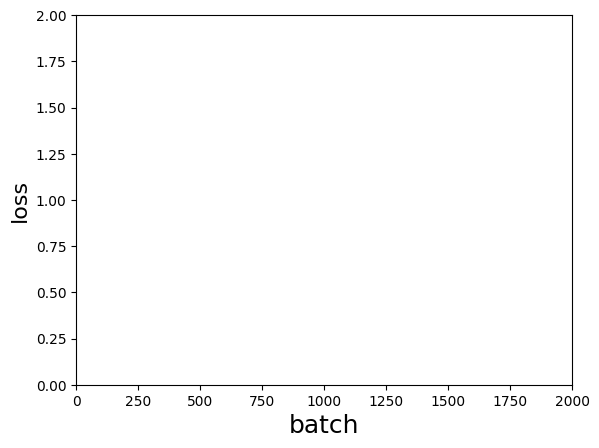

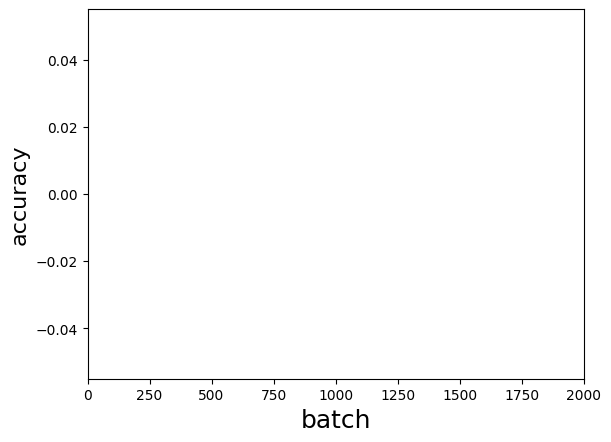

In [47]:
fig = plt.figure()
plt.plot([x[0] for x in d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()

fig = plt.figure()
plt.plot([x[3] for x in d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()

최종 학습된 결과를 random gaussian noise를 이용하여 생성

1/1 [==============================] - 1s 1s/step


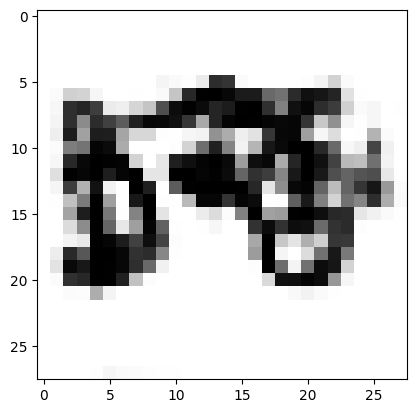

In [48]:
import numpy as np
#z_dim = 100

noise = np.random.normal(0, 1, (1, z_dim))
img = generator.predict(noise)
plt.imshow(img[0].squeeze(), cmap='binary')
plt.show()

epoch 20 생성 샘플

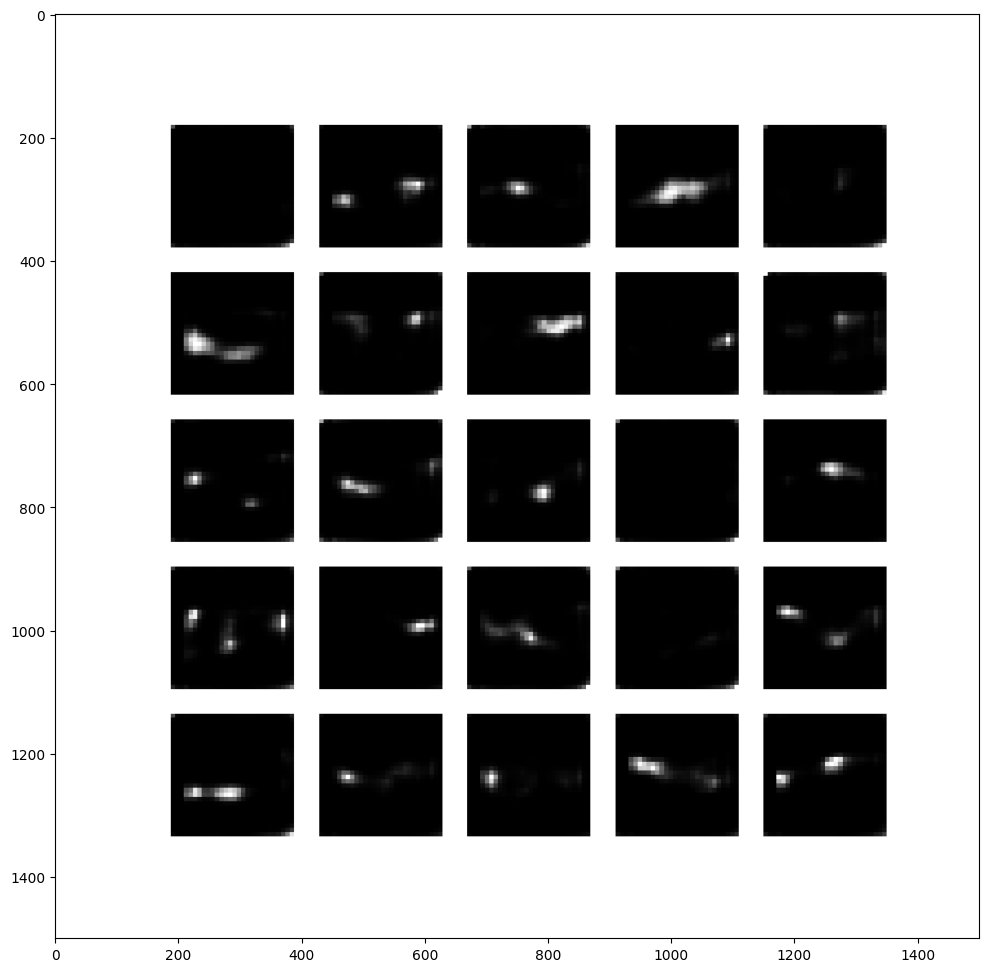

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

image = mp_image.imread('gan_data/images/sample_%d.png' % 20)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

epoch 100 생성 샘플

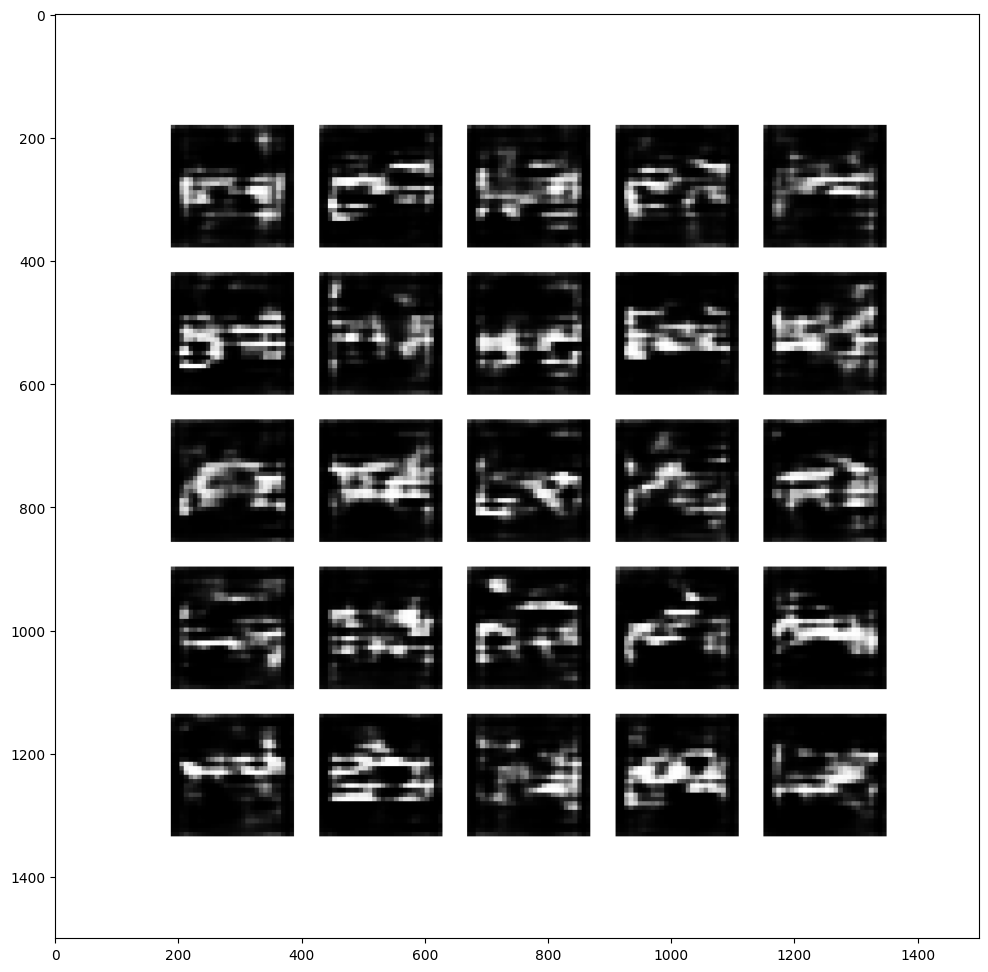

In [50]:
image = mp_image.imread('gan_data/images/sample_%d.png' % 100)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

epoch 200 생성 샘플

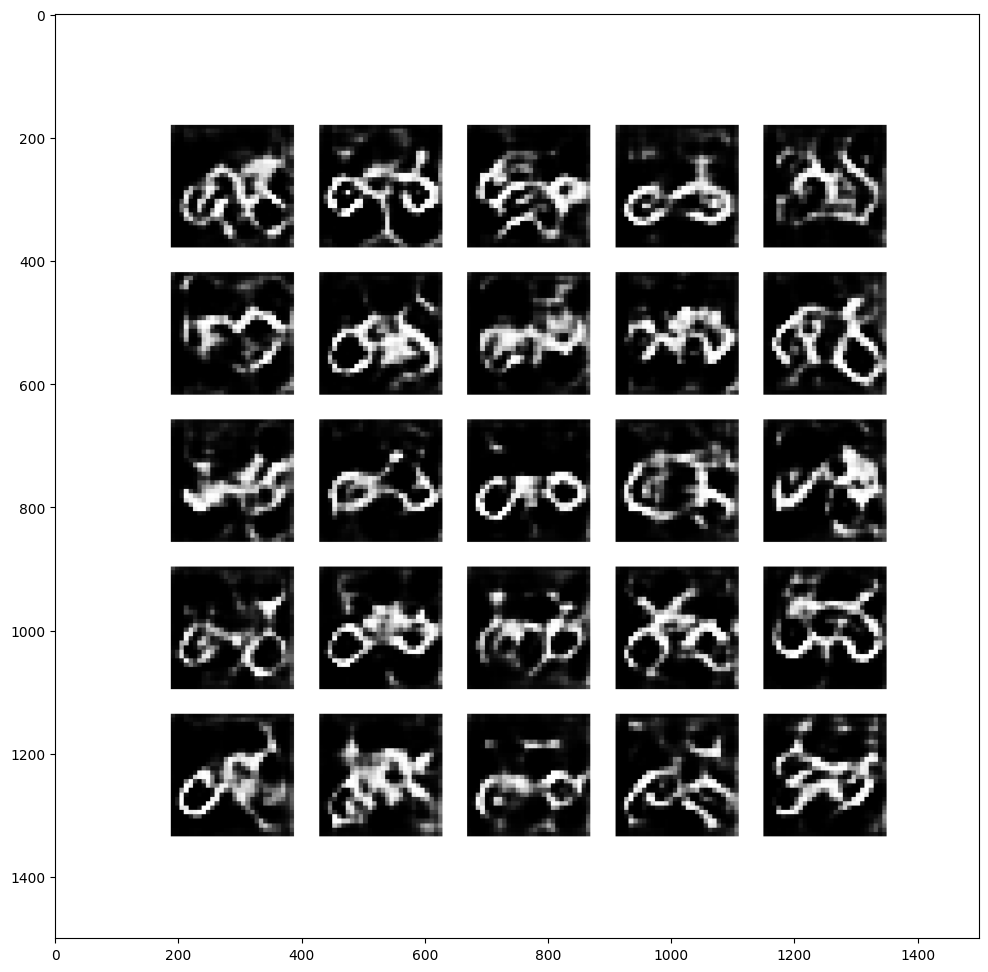

In [51]:
image = mp_image.imread('gan_data/images/sample_%d.png' % 200)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

epoch 1980 생성 샘플

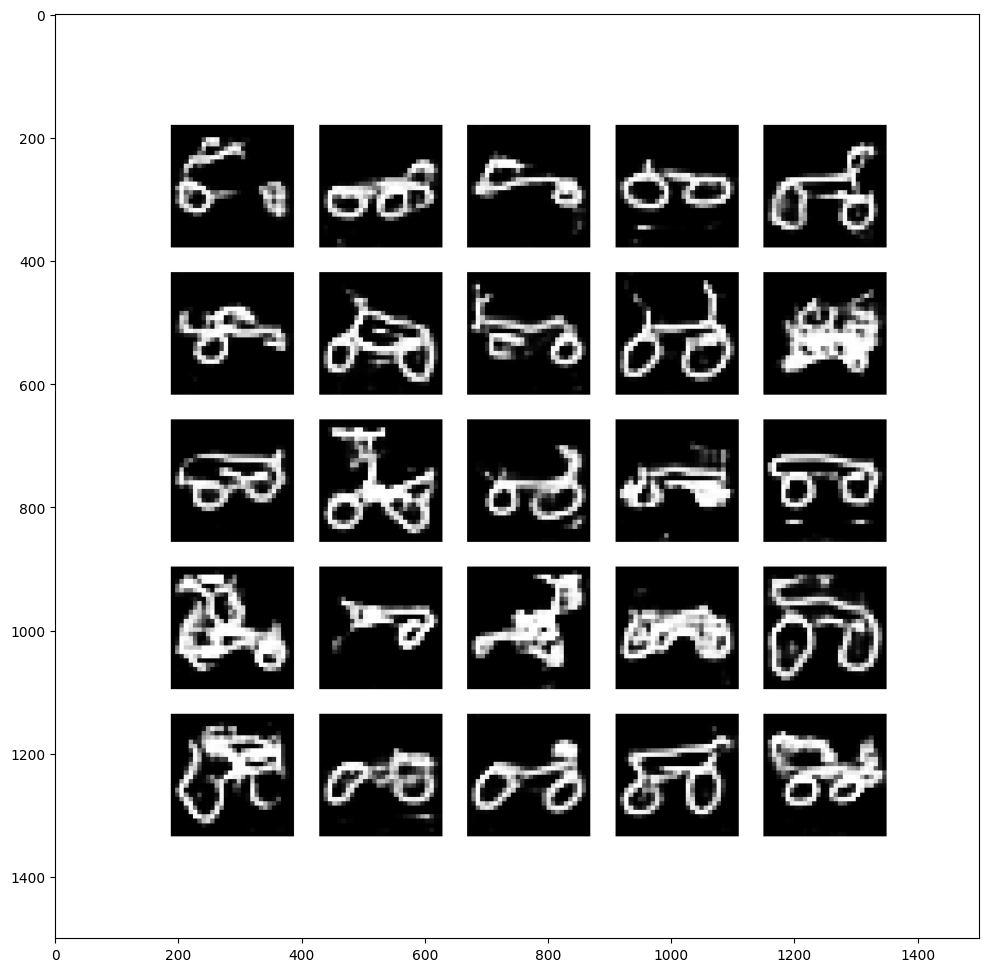

In [52]:
image = mp_image.imread('gan_data/images/sample_%d.png' % 1980)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()